In [8]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib
import axelrod as axl
import imp
import csv

assert pd.__version__ == "0.20.2"
assert np.__version__ == '1.12.1'
assert axl.__version__ == '2.13.0'
assert matplotlib.__version__ == "2.0.2"

import players
player_names = list(map(str, players.players))
number_of_digits = 3  # Number of digits to round for LaTeX tables

turns = 200
number_of_players = len(player_names)

assert number_of_players == 176

abbreviations = imp.load_source('abbreviations', '../src/abbreviations.py')
from abbreviations import abbreviations

def abbreviate(player_name, abbreviations=abbreviations):
    """
    Return the abbreviated name of a play if one has been given
    """
    if isinstance(player_name, axl.Player):
        player_name = str(player_name)
    return abbreviations.get(player_name, player_name)

assert abbreviate("Tit For Tat") == "TfT"
assert abbreviate("Random: 0.5") == "Random"
assert abbreviate(axl.TitForTat()) == "TfT"

with open("./reference_keys.csv", "r") as f:
    reader = csv.reader(f)
    reference_keys = {player: eval(keys) for player, keys in reader}
    
assert reference_keys['ALLCorALLD'] == ['axelrodproject']
assert reference_keys['Cooperator'] == ['Axelrod1984', 'Mittal2009', 'Press2012']

def clean_latex(string):
    """Replace some special carachters"""
    string = string.replace("textbackslashpi", "pi")
    string = string.replace("textbackslashphi", "phi")
    string = string.replace("\\$", "$")
    string = string.replace("\\$", "$")
    string = string.replace("\\textasciicircum", "^")
    string = string.replace("\_", "_")
    string = string.replace("2_2_2", "2\_2\_2")
    string = string.replace("1_1_1", "1\_1\_1")
    return string

# Write player appendix

In [10]:
with open("../assets/list_of_players.tex", "w") as f:
    for player in sorted(players.players, key=str):
        latex_name = "{}".format(player).replace("_", "\_")
        f.write("\item {}".format(latex_name))
        abbreviation = abbreviate(player)
        if abbreviation != player.name:
            f.write(" (\\textbf{{{}}})".format(abbreviation))
        if player.classifier["stochastic"]:
            f.write(" - \\textit{Stochastic}")
        else:
            f.write(" - \\textit{Deterministic}")
        try:
            mem = int(player.classifier["memory_depth"])
        except OverflowError:
            mem = "\(\infty\)"
        f.write(" - \\textit{{Memory depth}}: {}".format(mem))
        try:
            f.write(". \cite{{{}}}\n".format(", ".join(sorted(reference_keys[str(player)]))))
        except KeyError:
            f.write(".\n")

# Study the standard tournaments

## Scores

In [2]:
def read_scores(files):
    dfs = []
    for gz in files:
        if "scores" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    df /= turns * (number_of_players - 1)  # Scale all scores
    return df

In [3]:
standard_files = glob.glob("./data/*_0_1000*gz")
scores = read_scores(files=standard_files)

In [4]:
with open("../assets/standard_number_of_repetitions.tex", "w") as f:
    f.write(str(len(scores.index)))

In [5]:
def summarise_scores(scores):
    df = scores.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    df.drop('count', axis=1, inplace=True)
    return df

score_summary = summarise_scores(scores)
score_summary.head(15)

mean       std       min        5%       25%  \
EvolvedLookerUp2_2_2     2.954994  0.010307  2.915457  2.937143  2.948114   
Evolved HMM 5            2.954322  0.013947  2.902600  2.931200  2.944629   
Evolved FSM 16           2.952346  0.013213  2.900371  2.929657  2.943457   
PSO Gambler 2_2_2        2.938451  0.013253  2.884400  2.913657  2.930029   
Evolved FSM 16 Noise 05  2.919004  0.012535  2.874286  2.898200  2.910457   
PSO Gambler 1_1_1        2.911930  0.023452  2.809600  2.873284  2.896114   
Evolved ANN 5            2.911685  0.010219  2.870857  2.894229  2.904714   
Evolved FSM 4            2.909606  0.012088  2.868343  2.889086  2.901143   
Evolved ANN              2.907255  0.010004  2.865229  2.890314  2.900479   
PSO Gambler Mem1         2.901032  0.025442  2.782943  2.858257  2.883829   
Evolved ANN 5 Noise 05   2.864191  0.008258  2.835086  2.850171  2.858343   
DBS: 0.75, 3, 4, 3, 5    2.857138  0.008866  2.822743  2.842513  2.851000   
Winner12                 2.849322  0.008061  2.820000  2.835714  2.843486   
Fool Me Once             2.843965  0.008163  2.819314  2.830513  2.838000   
Omega TFT: 3, 8          2.840957  0.011286  2.800257  2.822143  2.833171   

                              50%       75%       95%       max  
EvolvedLookerUp2_2_2     2.955543  2.962543  2.970829  2.989400  
Evolved HMM 5            2.954343  2.964000  2.977114  3.007400  
Evolved FSM 16           2.952943  2.961886  2.973029  2.993171  
PSO Gambler 2_2_2        2.940200  2.948400  2.957257  2.971343  
Evolved FSM 16 Noise 05  2.919000  2.927657  2.939486  2.964457  
PSO Gambler 1_1_1        2.912143  2.927771  2.950259  3.011857  
Evolved ANN 5            2.911971  2.919229  2.927829  2.944543  
Evolved FSM 4            2.910200  2.918429  2.928514  2.941857  
Evolved ANN              2.907543  2.914457  2.923143  2.941629  
PSO Gambler Mem1         2.901343  2.918571  2.942629  2.994429  
Evolved ANN 5 Noise 05   2.864571  2.870314  2.877029  2.890943  
DBS: 0.75, 3, 4, 3, 5    2.857143  2.863343  2.871743  2.899371  
Winner12                 2.849771  2.855314  2.861914  2.872800  
Fool Me Once             2.844286  2.849657  2.857200  2.881943  
Omega TFT: 3, 8          2.841086  2.848829  2.859316  2.882143

In [6]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(score_summary.head(15).round(number_of_digits).to_latex()))

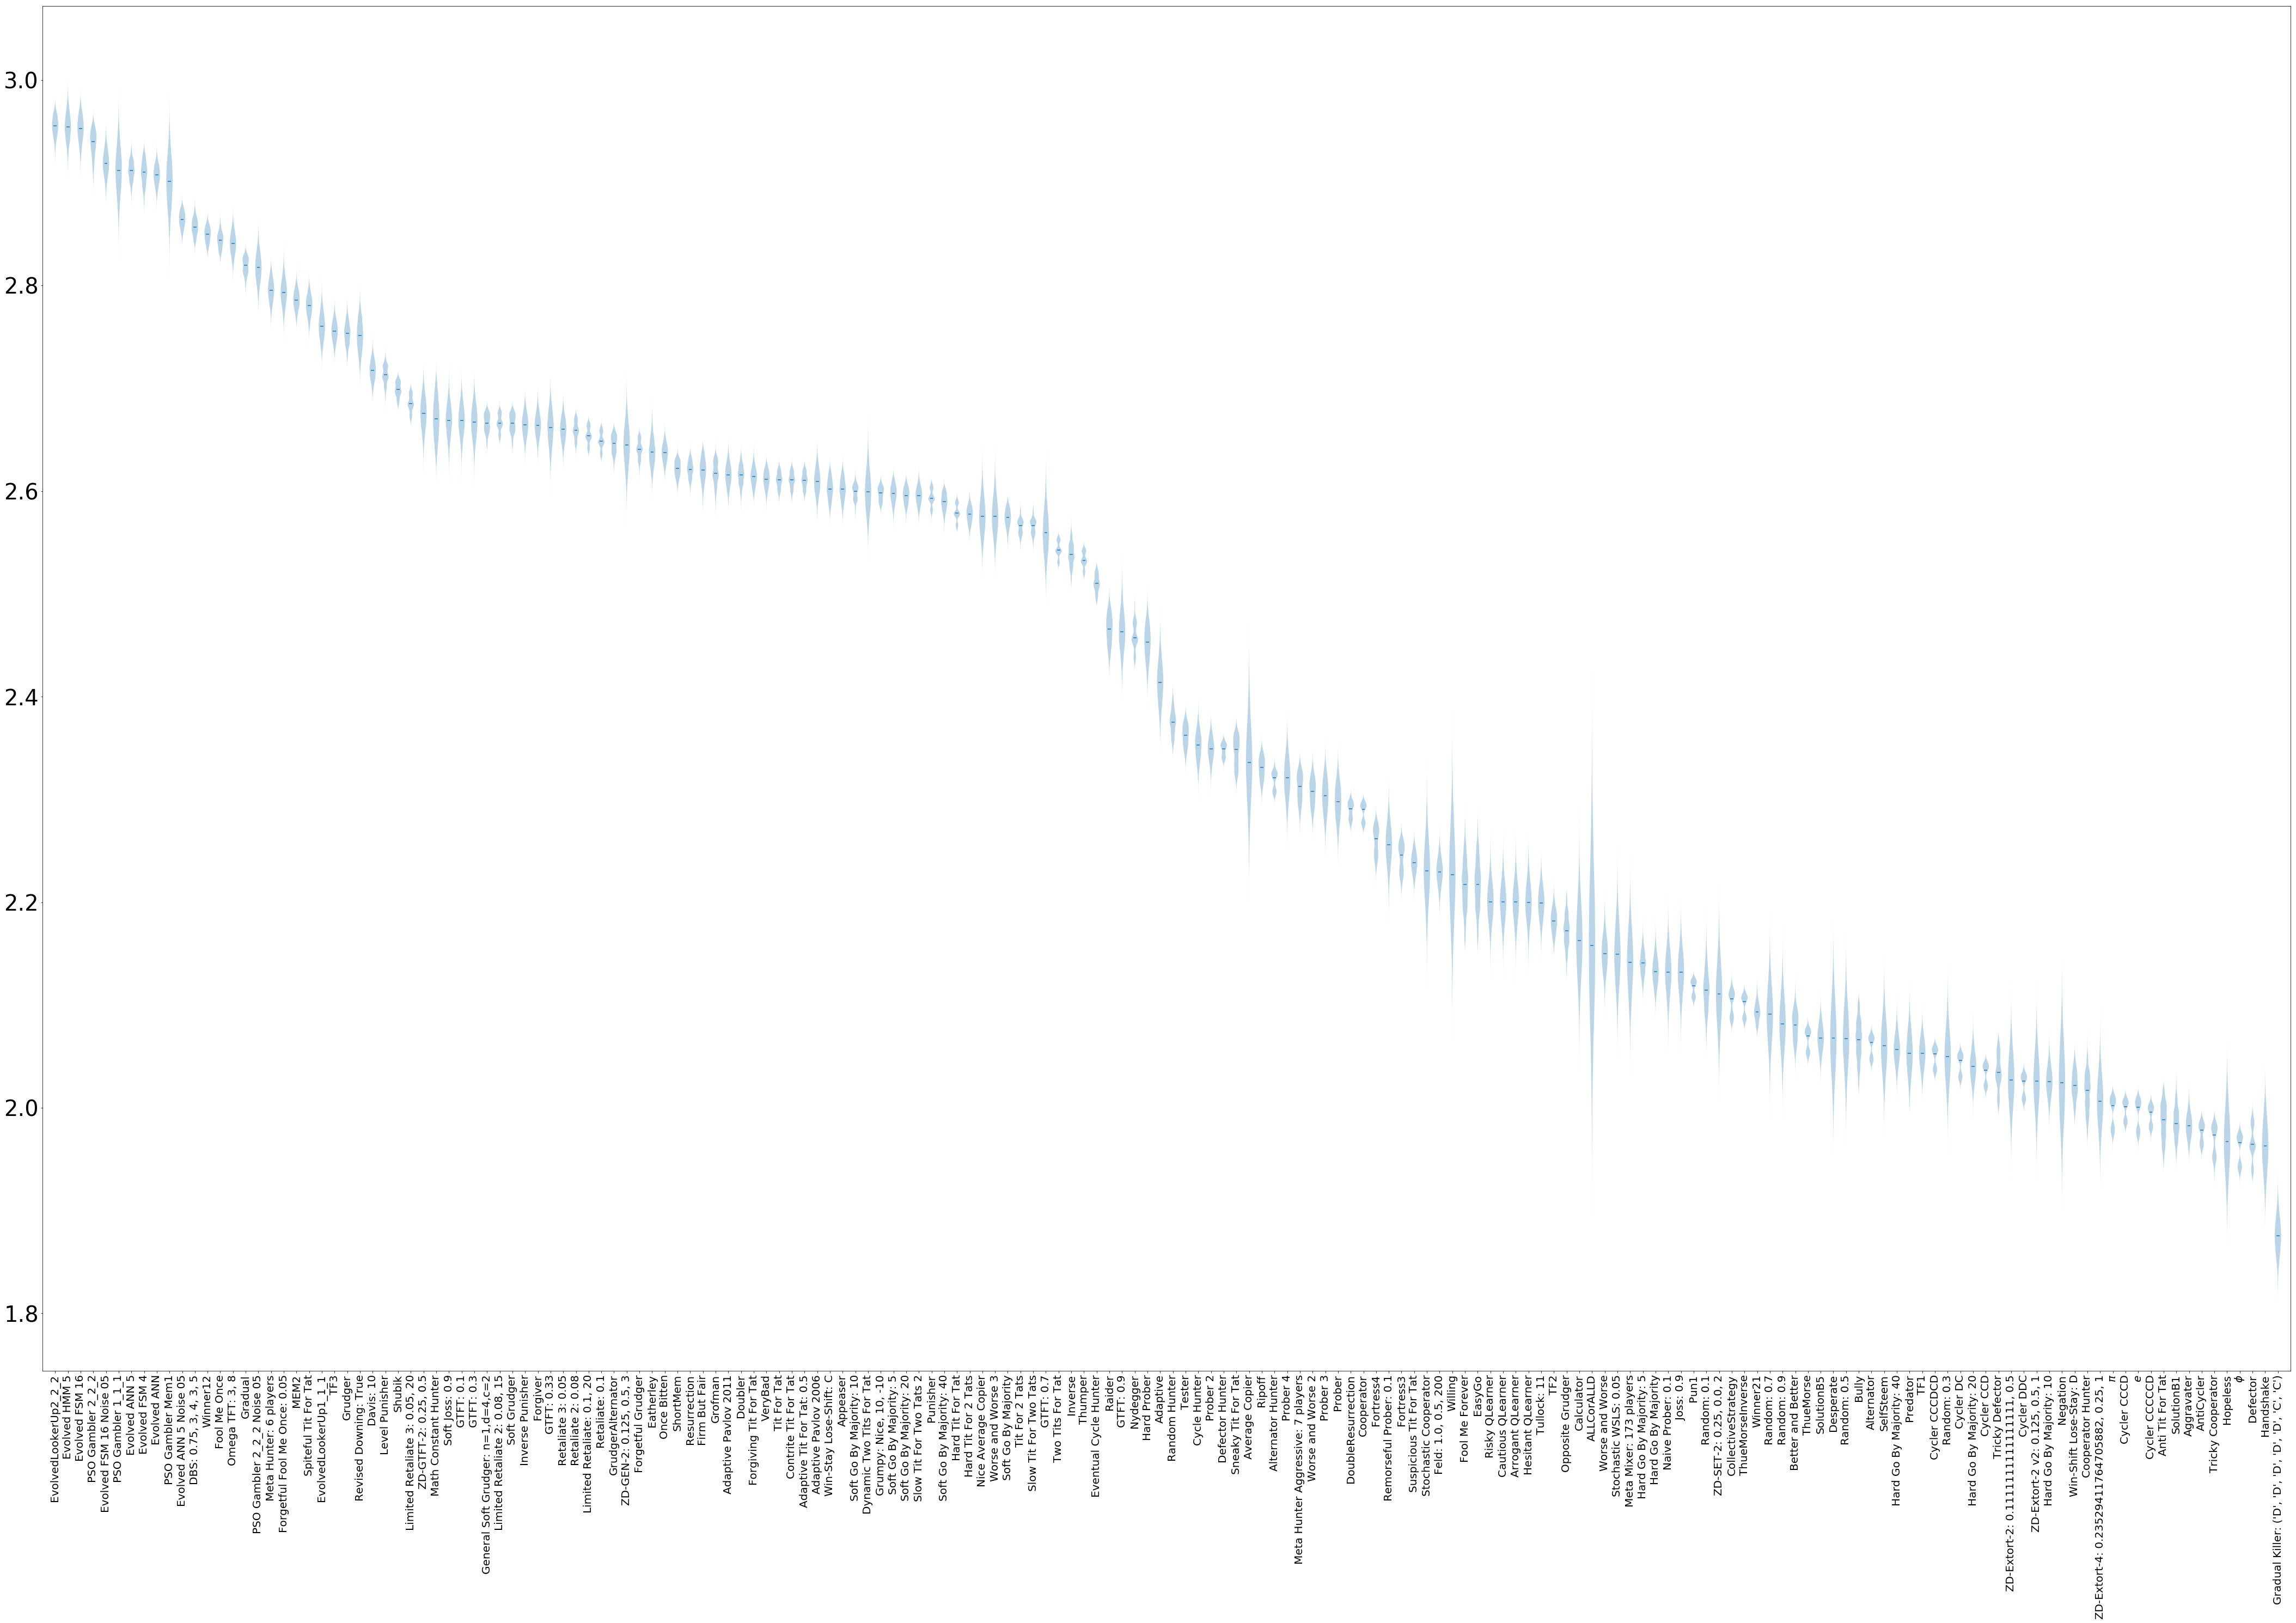

In [7]:
def violon_plot(scores, summary, filename):
    fig, ax = plt.subplots() 
    width = number_of_players / 3
    height = width / 1.414
    spacing = 4 
    positions = spacing * np.arange(1, number_of_players + 1, 1)
    fig.set_size_inches(width, height) 

    ax.violinplot([scores[player] for player in summary.index],
                  positions=positions, widths=spacing / 2,
                  showmedians=True, showextrema=False)
    ax.set_xticks(positions) 
    ax.set_xticklabels(summary.index, rotation=90)
    ax.set_xlim([0, spacing * (number_of_players + 1)])
    ax.tick_params(axis='x', which='both', labelsize=20)
    ax.tick_params(axis='y', which='both', labelsize=40)
    fig.tight_layout()
    fig.savefig(filename);
    
violon_plot(scores, score_summary, "../assets/standard_scores_boxplots.pdf")

## Ranks

Every row corresponds to a tournament. We can see the ranks of each strategy across the tournament repetitions.

In [8]:
def summarise_ranks(scores):
    df = scores.rank(axis=1, ascending=False).describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean")
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    return df

rank_summary = summarise_ranks(scores)
rank_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
EvolvedLookerUp2_2_2      2.171603  1.068075    1   1.0   1.0   2.0   3.0   
Evolved HMM 5             2.325956  1.276104    1   1.0   1.0   2.0   3.0   
Evolved FSM 16            2.487191  1.302948    1   1.0   1.0   2.0   3.0   
PSO Gambler 2_2_2         3.960074  1.523057    1   2.0   3.0   4.0   5.0   
Evolved FSM 16 Noise 05   6.298868  1.686112    1   4.0   5.0   6.0   7.0   
PSO Gambler 1_1_1         7.091574  2.503588    1   3.0   5.0   7.0   9.0   
Evolved ANN 5             7.283926  1.524512    2   5.0   6.0   7.0   8.0   
Evolved FSM 4             7.528603  1.630514    2   5.0   6.0   8.0   9.0   
Evolved ANN               7.895000  1.452708    2   5.0   7.0   8.0   9.0   
PSO Gambler Mem1          8.223029  2.535197    1   4.0   6.0   9.0  10.0   
Evolved ANN 5 Noise 05   11.363676  0.877084    8  10.0  11.0  11.0  12.0   
DBS: 0.75, 3, 4, 3, 5    12.188235  1.119743    9  11.0  11.0  12.0  13.0   
Winner12                 13.223206  1.141186    9  11.0  12.0  13.0  14.0   
Fool Me Once             13.964176  1.078964    9  12.0  13.0  14.0  15.0   
Omega TFT: 3, 8          14.269676  1.299712    9  12.0  13.0  15.0  15.0   

                          95%  max  
EvolvedLookerUp2_2_2      4.0    8  
Evolved HMM 5             5.0   10  
Evolved FSM 16            5.0   10  
PSO Gambler 2_2_2         7.0   10  
Evolved FSM 16 Noise 05   9.0   11  
PSO Gambler 1_1_1        10.0   17  
Evolved ANN 5            10.0   11  
Evolved FSM 4            10.0   12  
Evolved ANN              10.0   12  
PSO Gambler Mem1         12.0   20  
Evolved ANN 5 Noise 05   13.0   16  
DBS: 0.75, 3, 4, 3, 5    14.0   16  
Winner12                 15.0   17  
Fool Me Once             15.0   17  
Omega TFT: 3, 8          16.0   19

In [9]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(rank_summary.head(15).round(number_of_digits).to_latex()))

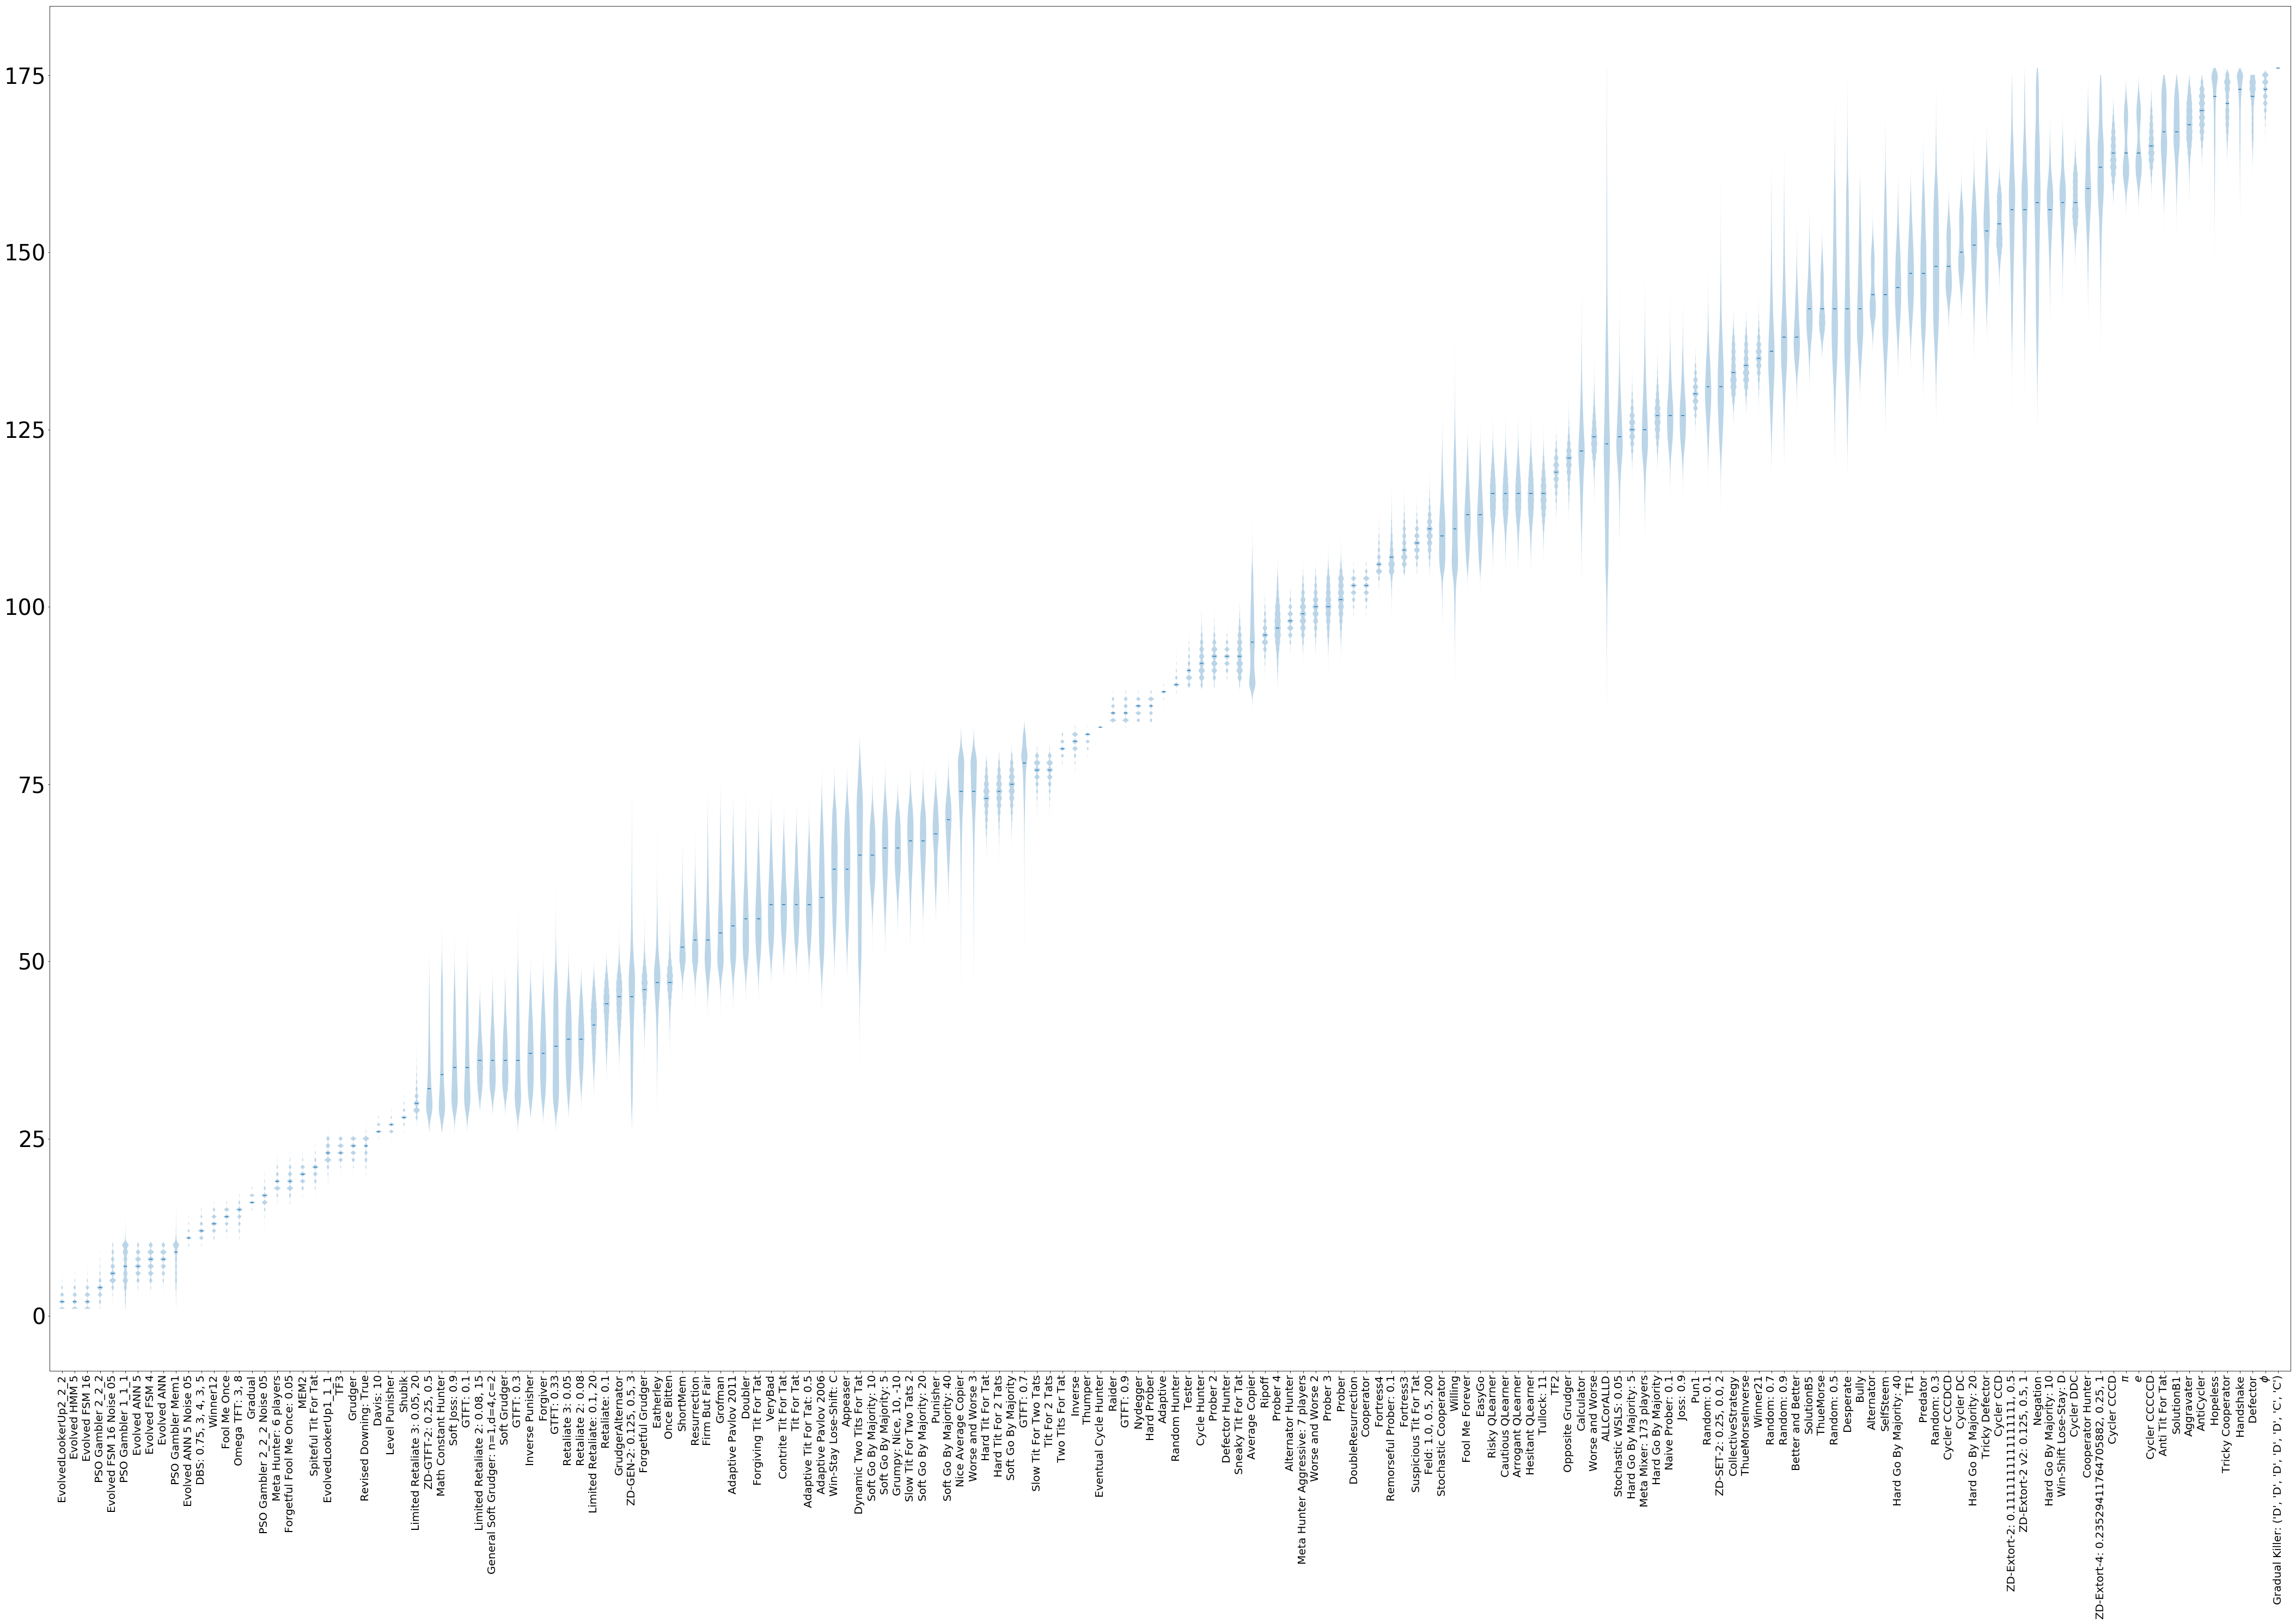

In [10]:
violon_plot(scores.rank(axis=1, ascending=False), rank_summary, "../assets/standard_ranks_boxplots.pdf")

## Payoff matrix

As all the individual payoff matrix files have the mean values and they all have the same number of repetitions, the mean of the means is the mean over all tournaments.

In [11]:
def read_payoff_matrix(files):
    arrays = []
    for gz in files:
        if "payoff_matrix" in gz:
            arrays.append(np.array(pd.read_csv(gz, header=None)))  # Read through pd to deal with float conversion
    return sum(arrays) / len(arrays)

In [12]:
payoff_matrix = read_payoff_matrix(files=standard_files)
assert payoff_matrix.shape == (176, 176)

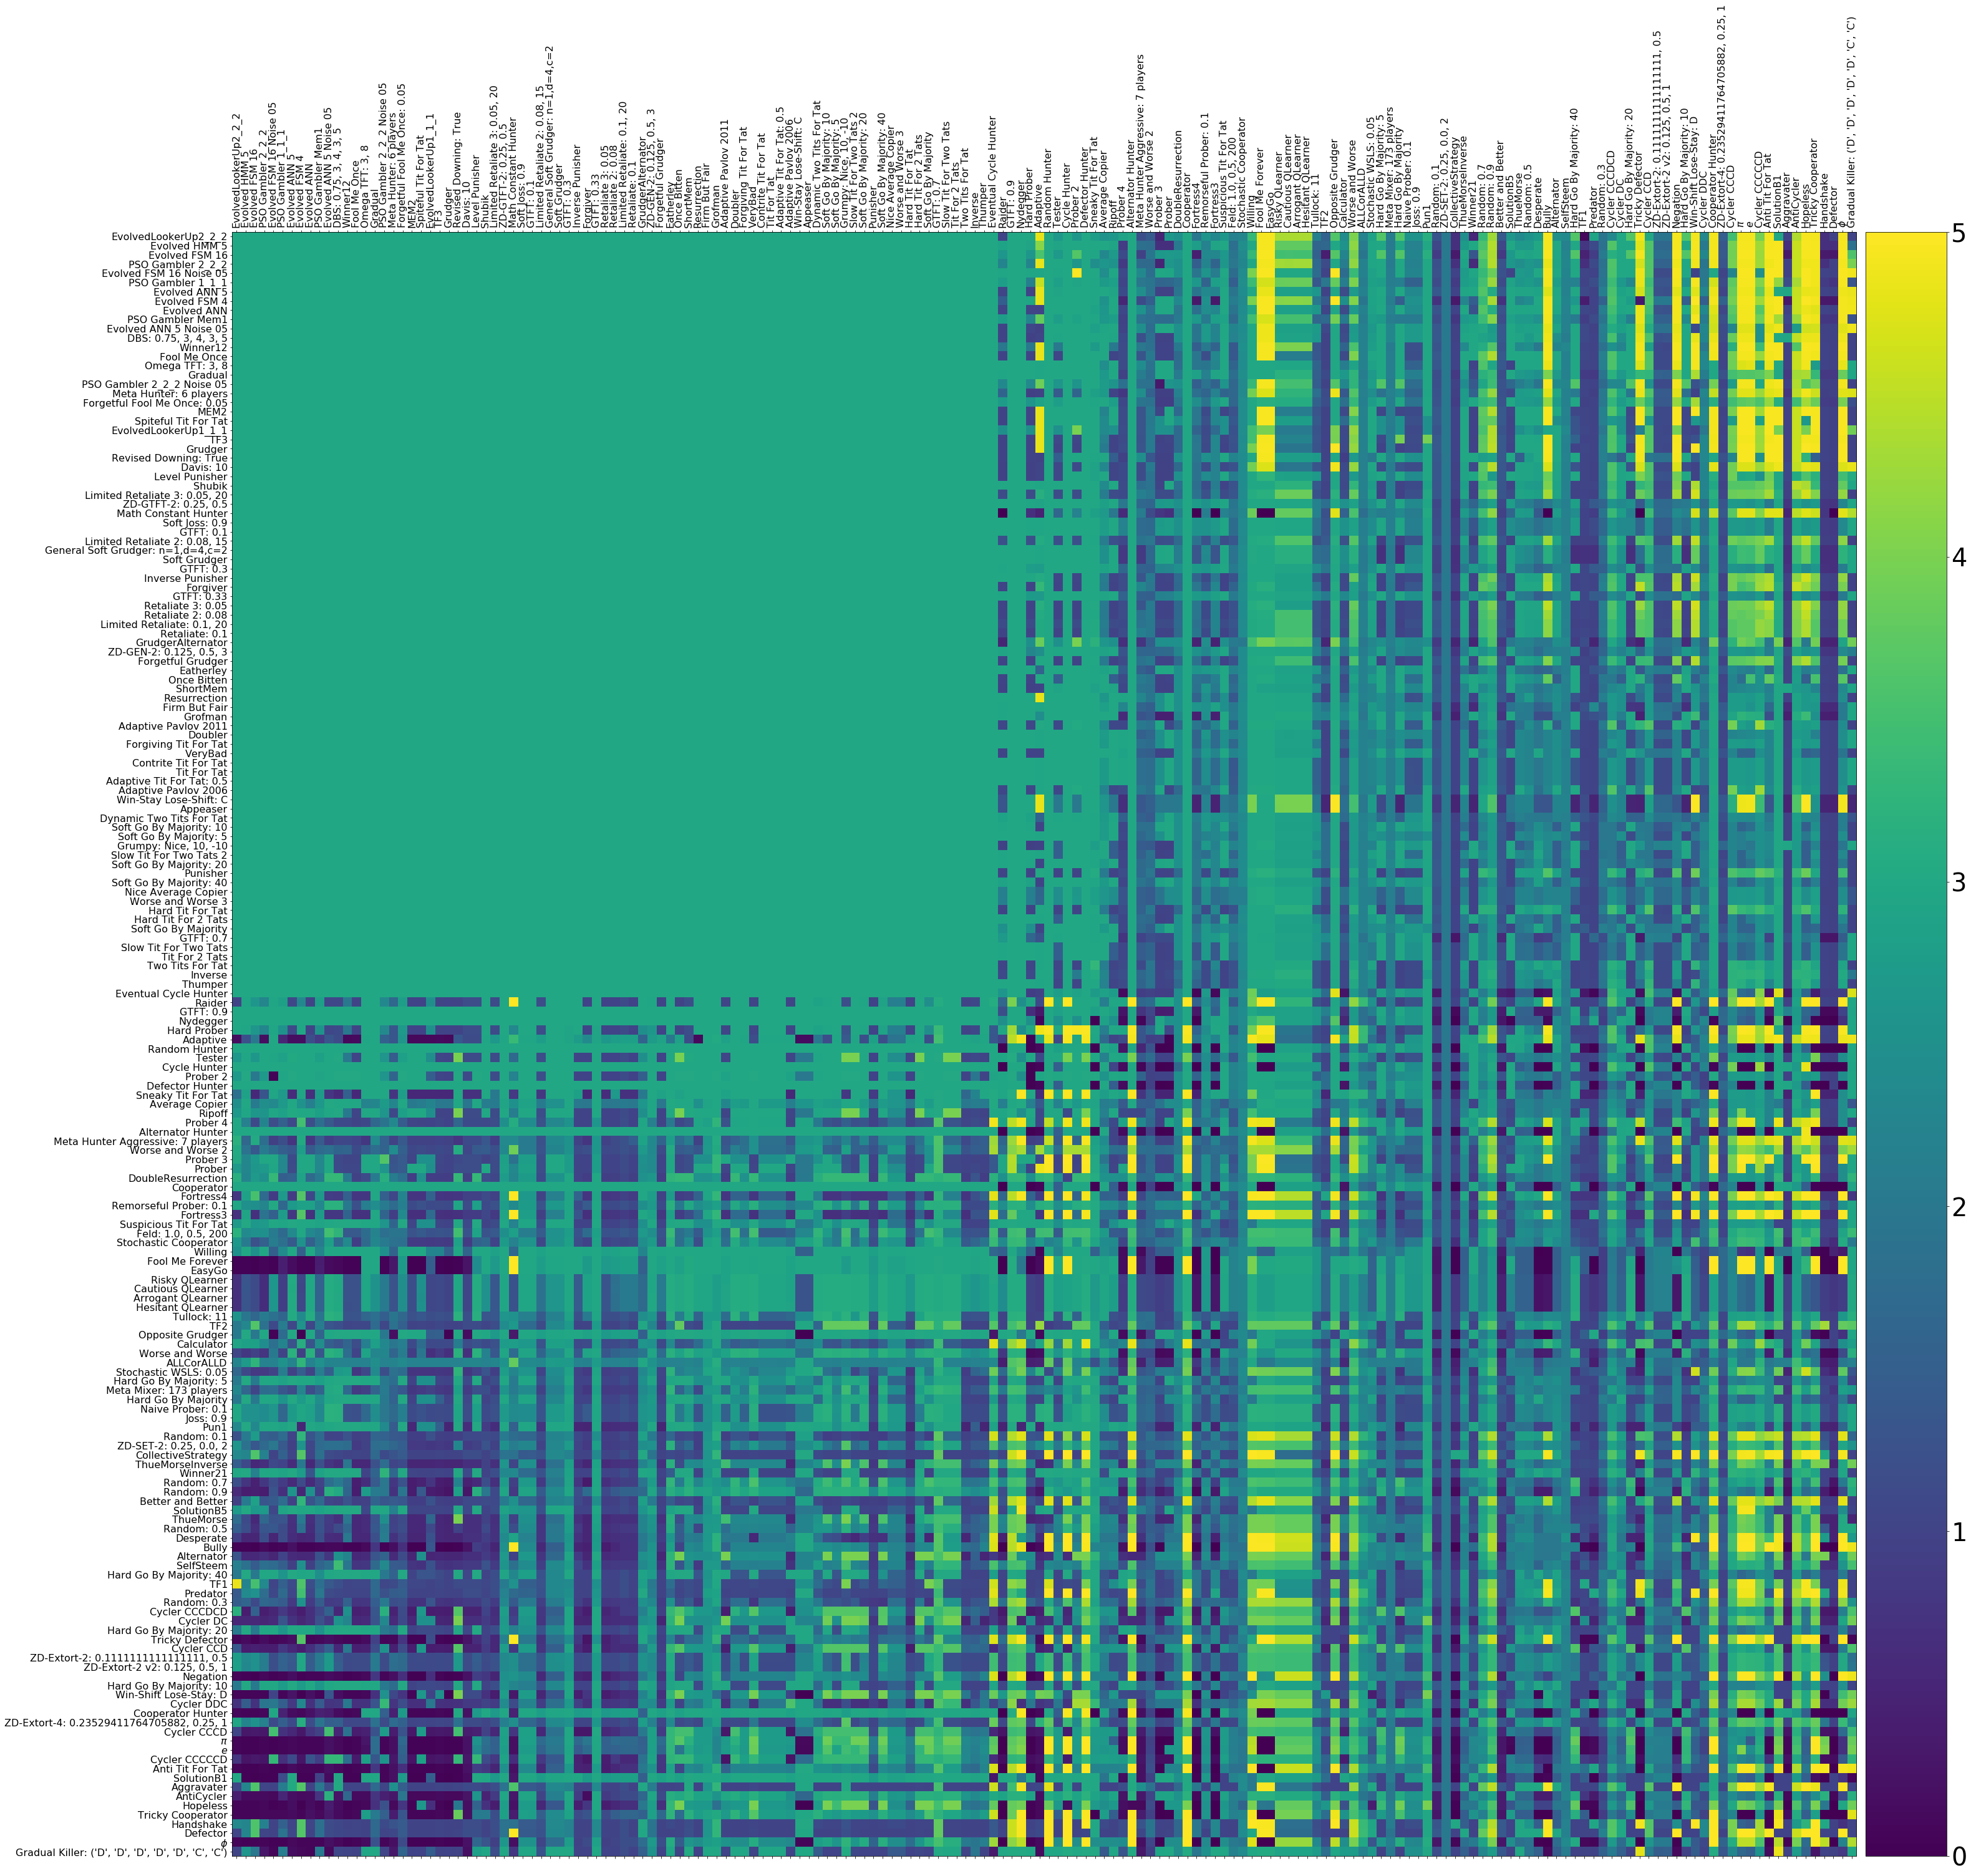

In [13]:
def payoff_heatmap(matrix, ranked_player_names, filename):
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_xticks(range(number_of_players))
    ax.set_yticks(range(number_of_players))
    ax.set_xticklabels(ranked_player_names, rotation=90)
    ax.set_yticklabels(ranked_player_names)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cax.tick_params(labelsize=40) 
    fig.colorbar(mat, cax=cax)

    fig.tight_layout()
    fig.savefig(filename);
    
ranked_player_names = list(rank_summary.index)
ranked_indices = [player_names.index(name) for name in ranked_player_names]
ranked_payoff_matrix = payoff_matrix[ranked_indices][:, ranked_indices]
payoff_heatmap(ranked_payoff_matrix, ranked_player_names, "../assets/standard_scores_heatmap.pdf")

## Head to head wins

In [14]:
def read_wins(files):
    dfs = []
    for gz in files:
        if "wins" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    return df

In [15]:
wins = read_wins(files=standard_files)

In [16]:
def summarise_wins(wins, score_summary):
    df = wins.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    return df.loc[score_summary.index]

win_summary = summarise_wins(wins, score_summary)
win_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
EvolvedLookerUp2_2_2     48.263206  1.336626   43  46.0  47.0  48.0  49.0   
Evolved HMM 5            41.364412  1.220564   37  39.0  41.0  41.0  42.0   
Evolved FSM 16           56.980147  1.099342   51  55.0  56.0  57.0  58.0   
PSO Gambler 2_2_2        40.685882  1.092870   36  39.0  40.0  41.0  41.0   
Evolved FSM 16 Noise 05  40.079059  1.670596   34  37.0  39.0  40.0  41.0   
PSO Gambler 1_1_1        45.001088  1.598322   38  42.0  44.0  45.0  46.0   
Evolved ANN 5            43.225765  0.674700   41  42.0  43.0  43.0  44.0   
Evolved FSM 4            37.227529  0.951914   34  36.0  37.0  37.0  38.0   
Evolved ANN              43.097176  1.020899   40  42.0  42.0  43.0  44.0   
PSO Gambler Mem1         43.443059  1.839063   34  40.0  42.0  43.0  45.0   
Evolved ANN 5 Noise 05   33.708853  1.125326   30  32.0  33.0  34.0  34.0   
DBS: 0.75, 3, 4, 3, 5    32.327235  1.196670   28  30.0  32.0  32.0  33.0   
Winner12                 40.174559  1.035688   36  39.0  39.0  40.0  41.0   
Fool Me Once             50.123265  0.424215   48  50.0  50.0  50.0  50.0   
Omega TFT: 3, 8          35.157559  0.862276   32  34.0  35.0  35.0  36.0   

                          95%  max  
EvolvedLookerUp2_2_2     50.0   53  
Evolved HMM 5            43.0   45  
Evolved FSM 16           59.0   60  
PSO Gambler 2_2_2        42.0   45  
Evolved FSM 16 Noise 05  43.0   47  
PSO Gambler 1_1_1        48.0   51  
Evolved ANN 5            44.0   47  
Evolved FSM 4            39.0   41  
Evolved ANN              45.0   48  
PSO Gambler Mem1         46.0   51  
Evolved ANN 5 Noise 05   35.0   38  
DBS: 0.75, 3, 4, 3, 5    34.0   37  
Winner12                 42.0   44  
Fool Me Once             51.0   52  
Omega TFT: 3, 8          37.0   39

In [17]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.head(15).round(number_of_digits).to_latex()))

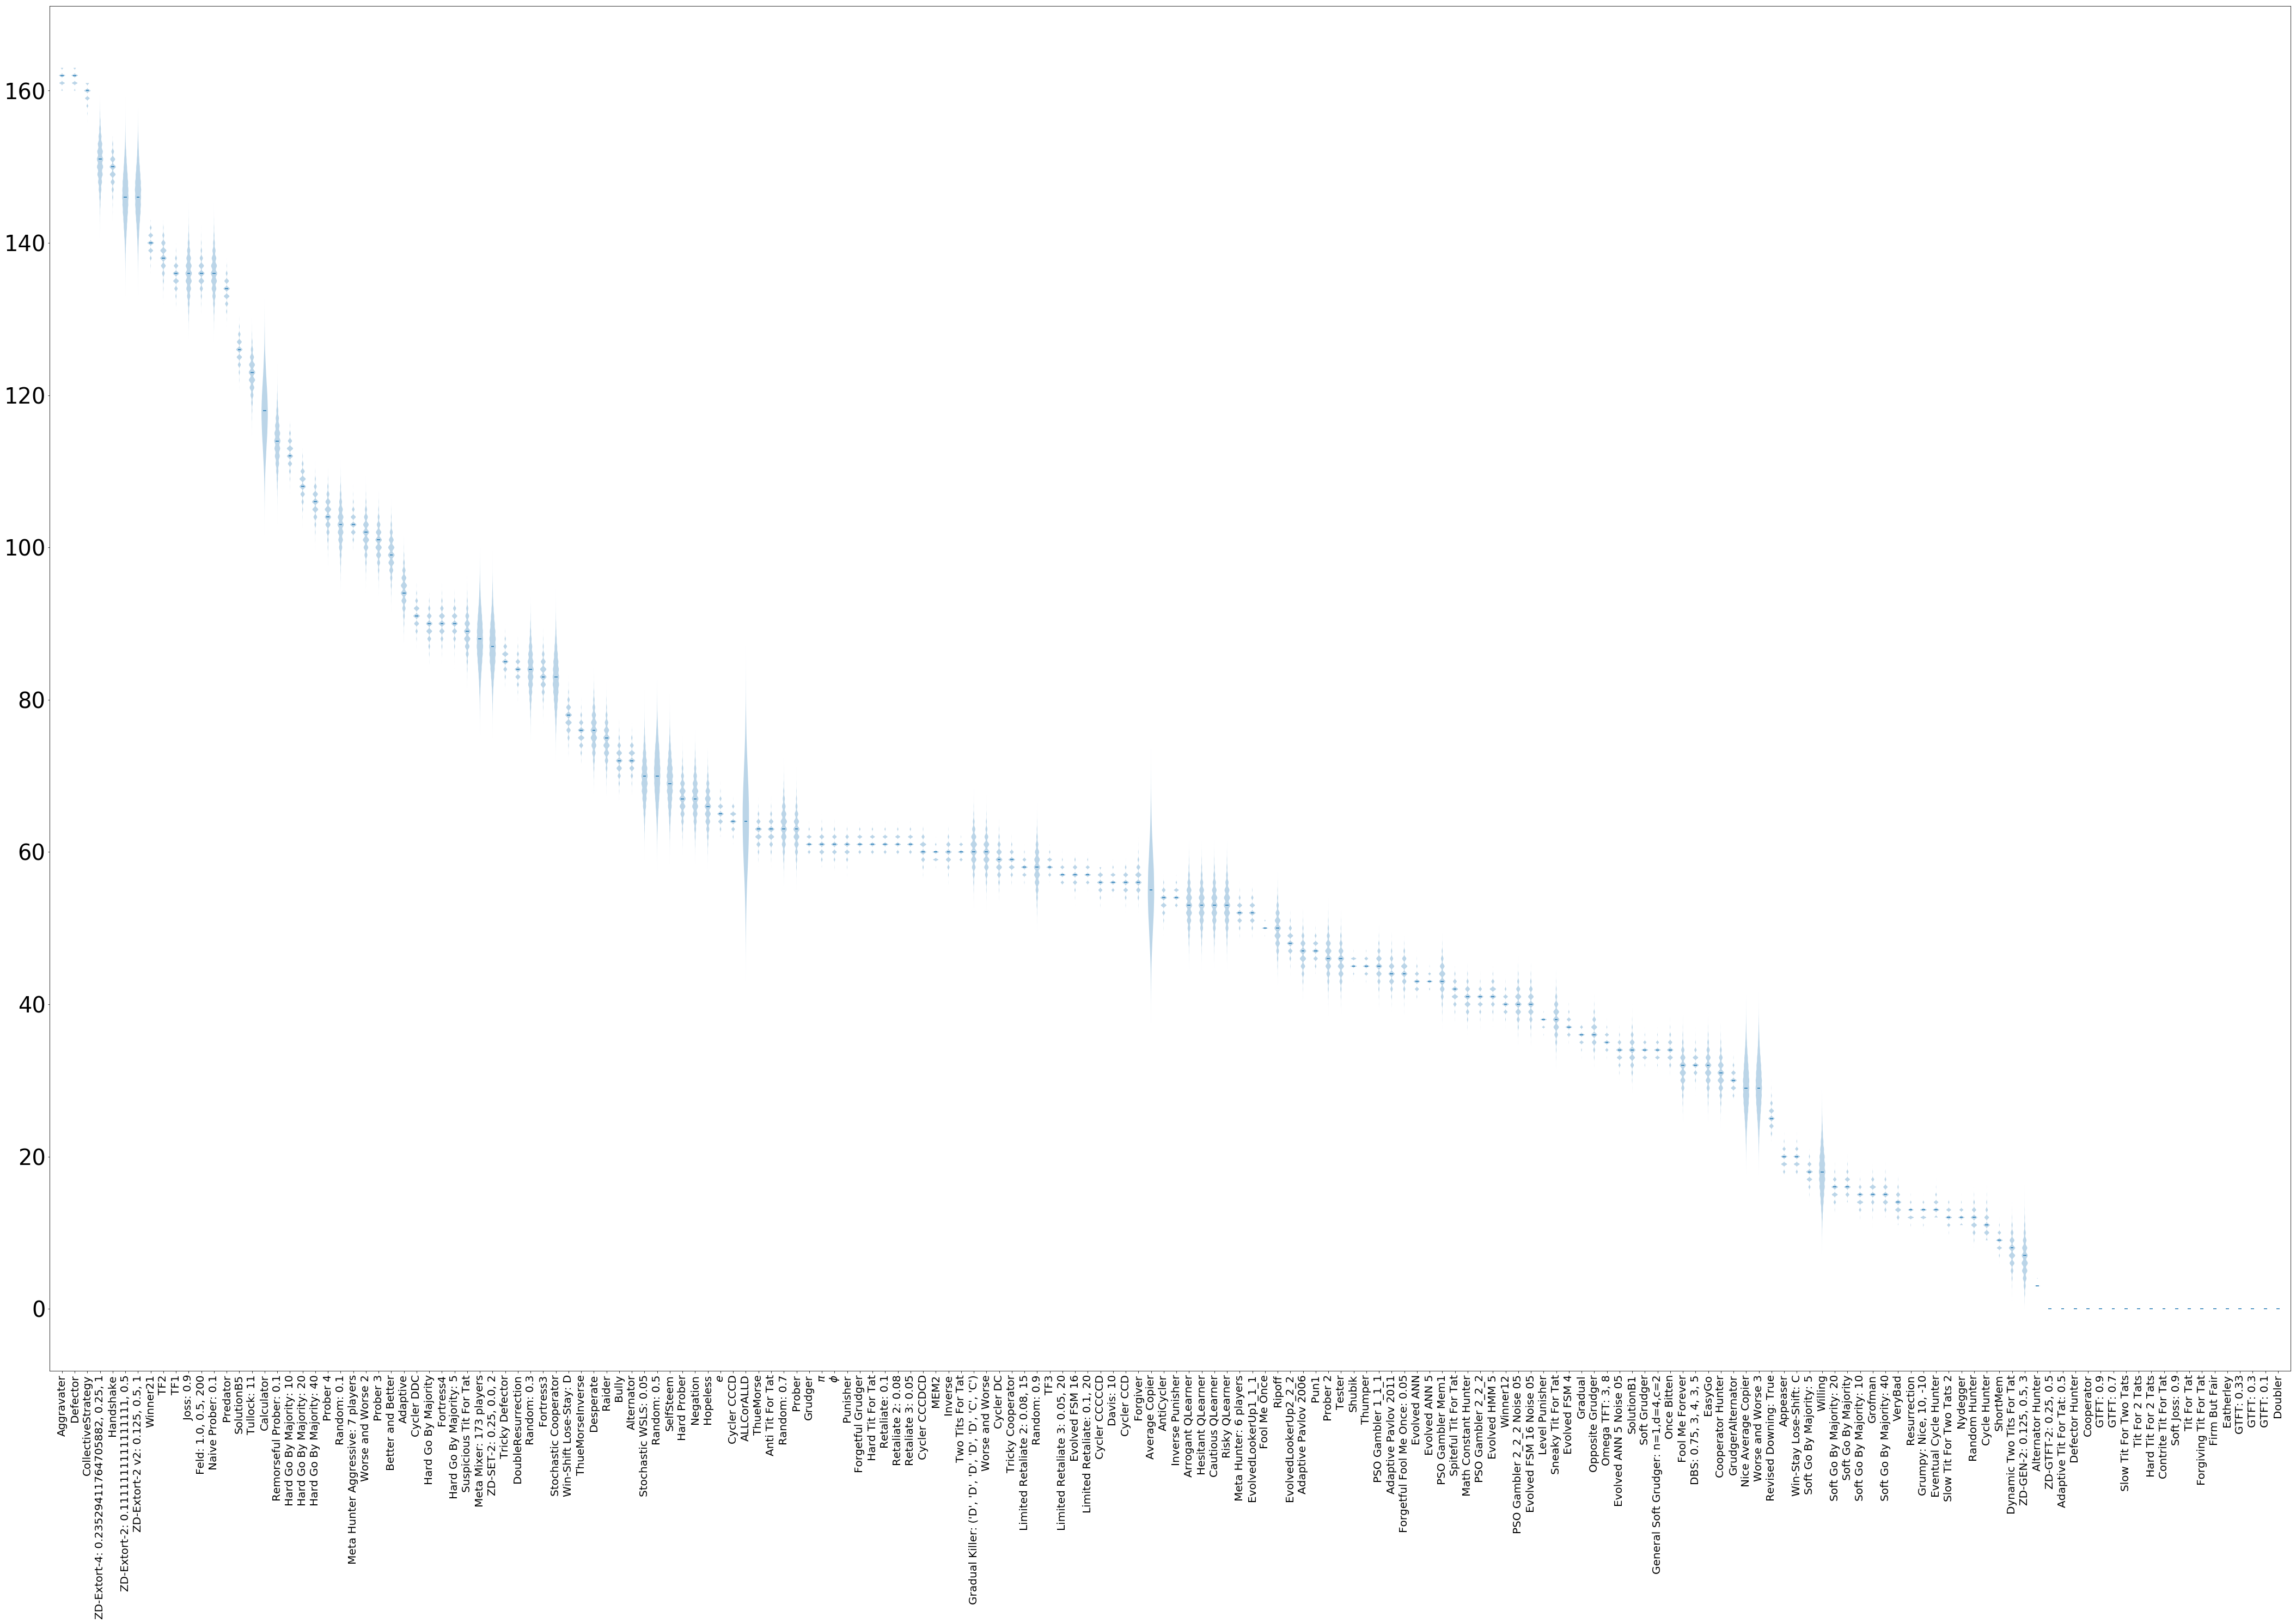

In [18]:
win_summary = win_summary.sort_values("50%", ascending=False)
violon_plot(wins, win_summary, "../assets/standard_wins_boxplots.pdf")

# Study the noisy tournaments


## Scores

In [19]:
noisy_files = glob.glob("./data/*_5_1000*gz")
scores = read_scores(files=noisy_files)

In [20]:
with open("../assets/noisy_number_of_repetitions.tex", "w") as f:
    f.write(str(len(scores.index)))

In [21]:
score_summary = summarise_scores(scores)
score_summary.head(15)

mean       std       min        5%       25%  \
DBS: 0.75, 3, 4, 3, 5       2.572694  0.024533  2.473857  2.533027  2.556143   
Evolved ANN 5 Noise 05      2.533786  0.025337  2.417857  2.491571  2.516943   
Evolved FSM 16 Noise 05     2.514924  0.030823  2.374400  2.464229  2.494229   
Evolved ANN 5               2.409535  0.030413  2.291800  2.359143  2.389221   
Evolved FSM 4               2.392716  0.027061  2.286343  2.348199  2.374457   
Evolved HMM 5               2.391556  0.026147  2.289457  2.348400  2.373743   
Level Punisher              2.388405  0.025002  2.280600  2.347084  2.371714   
Omega TFT: 3, 8             2.387181  0.026176  2.269514  2.343456  2.369657   
Spiteful Tit For Tat        2.383098  0.029747  2.259200  2.334429  2.362993   
Evolved FSM 16              2.375041  0.029504  2.244714  2.326114  2.355393   
PSO Gambler 2_2_2 Noise 05  2.370811  0.028803  2.249514  2.323086  2.351829   
Adaptive                    2.369218  0.038104  2.217486  2.306371  2.343714   
Evolved ANN                 2.365473  0.021857  2.276200  2.329400  2.350771   
Math Constant Hunter        2.344171  0.022460  2.257286  2.307857  2.328971   
Gradual                     2.341045  0.021200  2.247943  2.305971  2.326800   

                                 50%       75%       95%       max  
DBS: 0.75, 3, 4, 3, 5       2.572571  2.589057  2.613544  2.667343  
Evolved ANN 5 Noise 05      2.534314  2.551171  2.574714  2.629000  
Evolved FSM 16 Noise 05     2.515143  2.535857  2.565257  2.642143  
Evolved ANN 5               2.409543  2.430114  2.459086  2.535771  
Evolved FSM 4               2.392629  2.411029  2.437201  2.496286  
Evolved HMM 5               2.391657  2.409379  2.434716  2.493457  
Level Punisher              2.388514  2.405314  2.429086  2.487286  
Omega TFT: 3, 8             2.387543  2.405000  2.429600  2.498114  
Spiteful Tit For Tat        2.383143  2.402914  2.432200  2.516771  
Evolved FSM 16              2.375514  2.395143  2.422943  2.494343  
PSO Gambler 2_2_2 Noise 05  2.371086  2.390121  2.418000  2.480200  
Adaptive                    2.369229  2.395236  2.431857  2.523629  
Evolved ANN                 2.365543  2.380143  2.401457  2.482857  
Math Constant Hunter        2.343886  2.359029  2.381944  2.432314  
Gradual                     2.341286  2.355457  2.375514  2.429371

In [22]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(score_summary.head(15).round(number_of_digits).to_latex()))

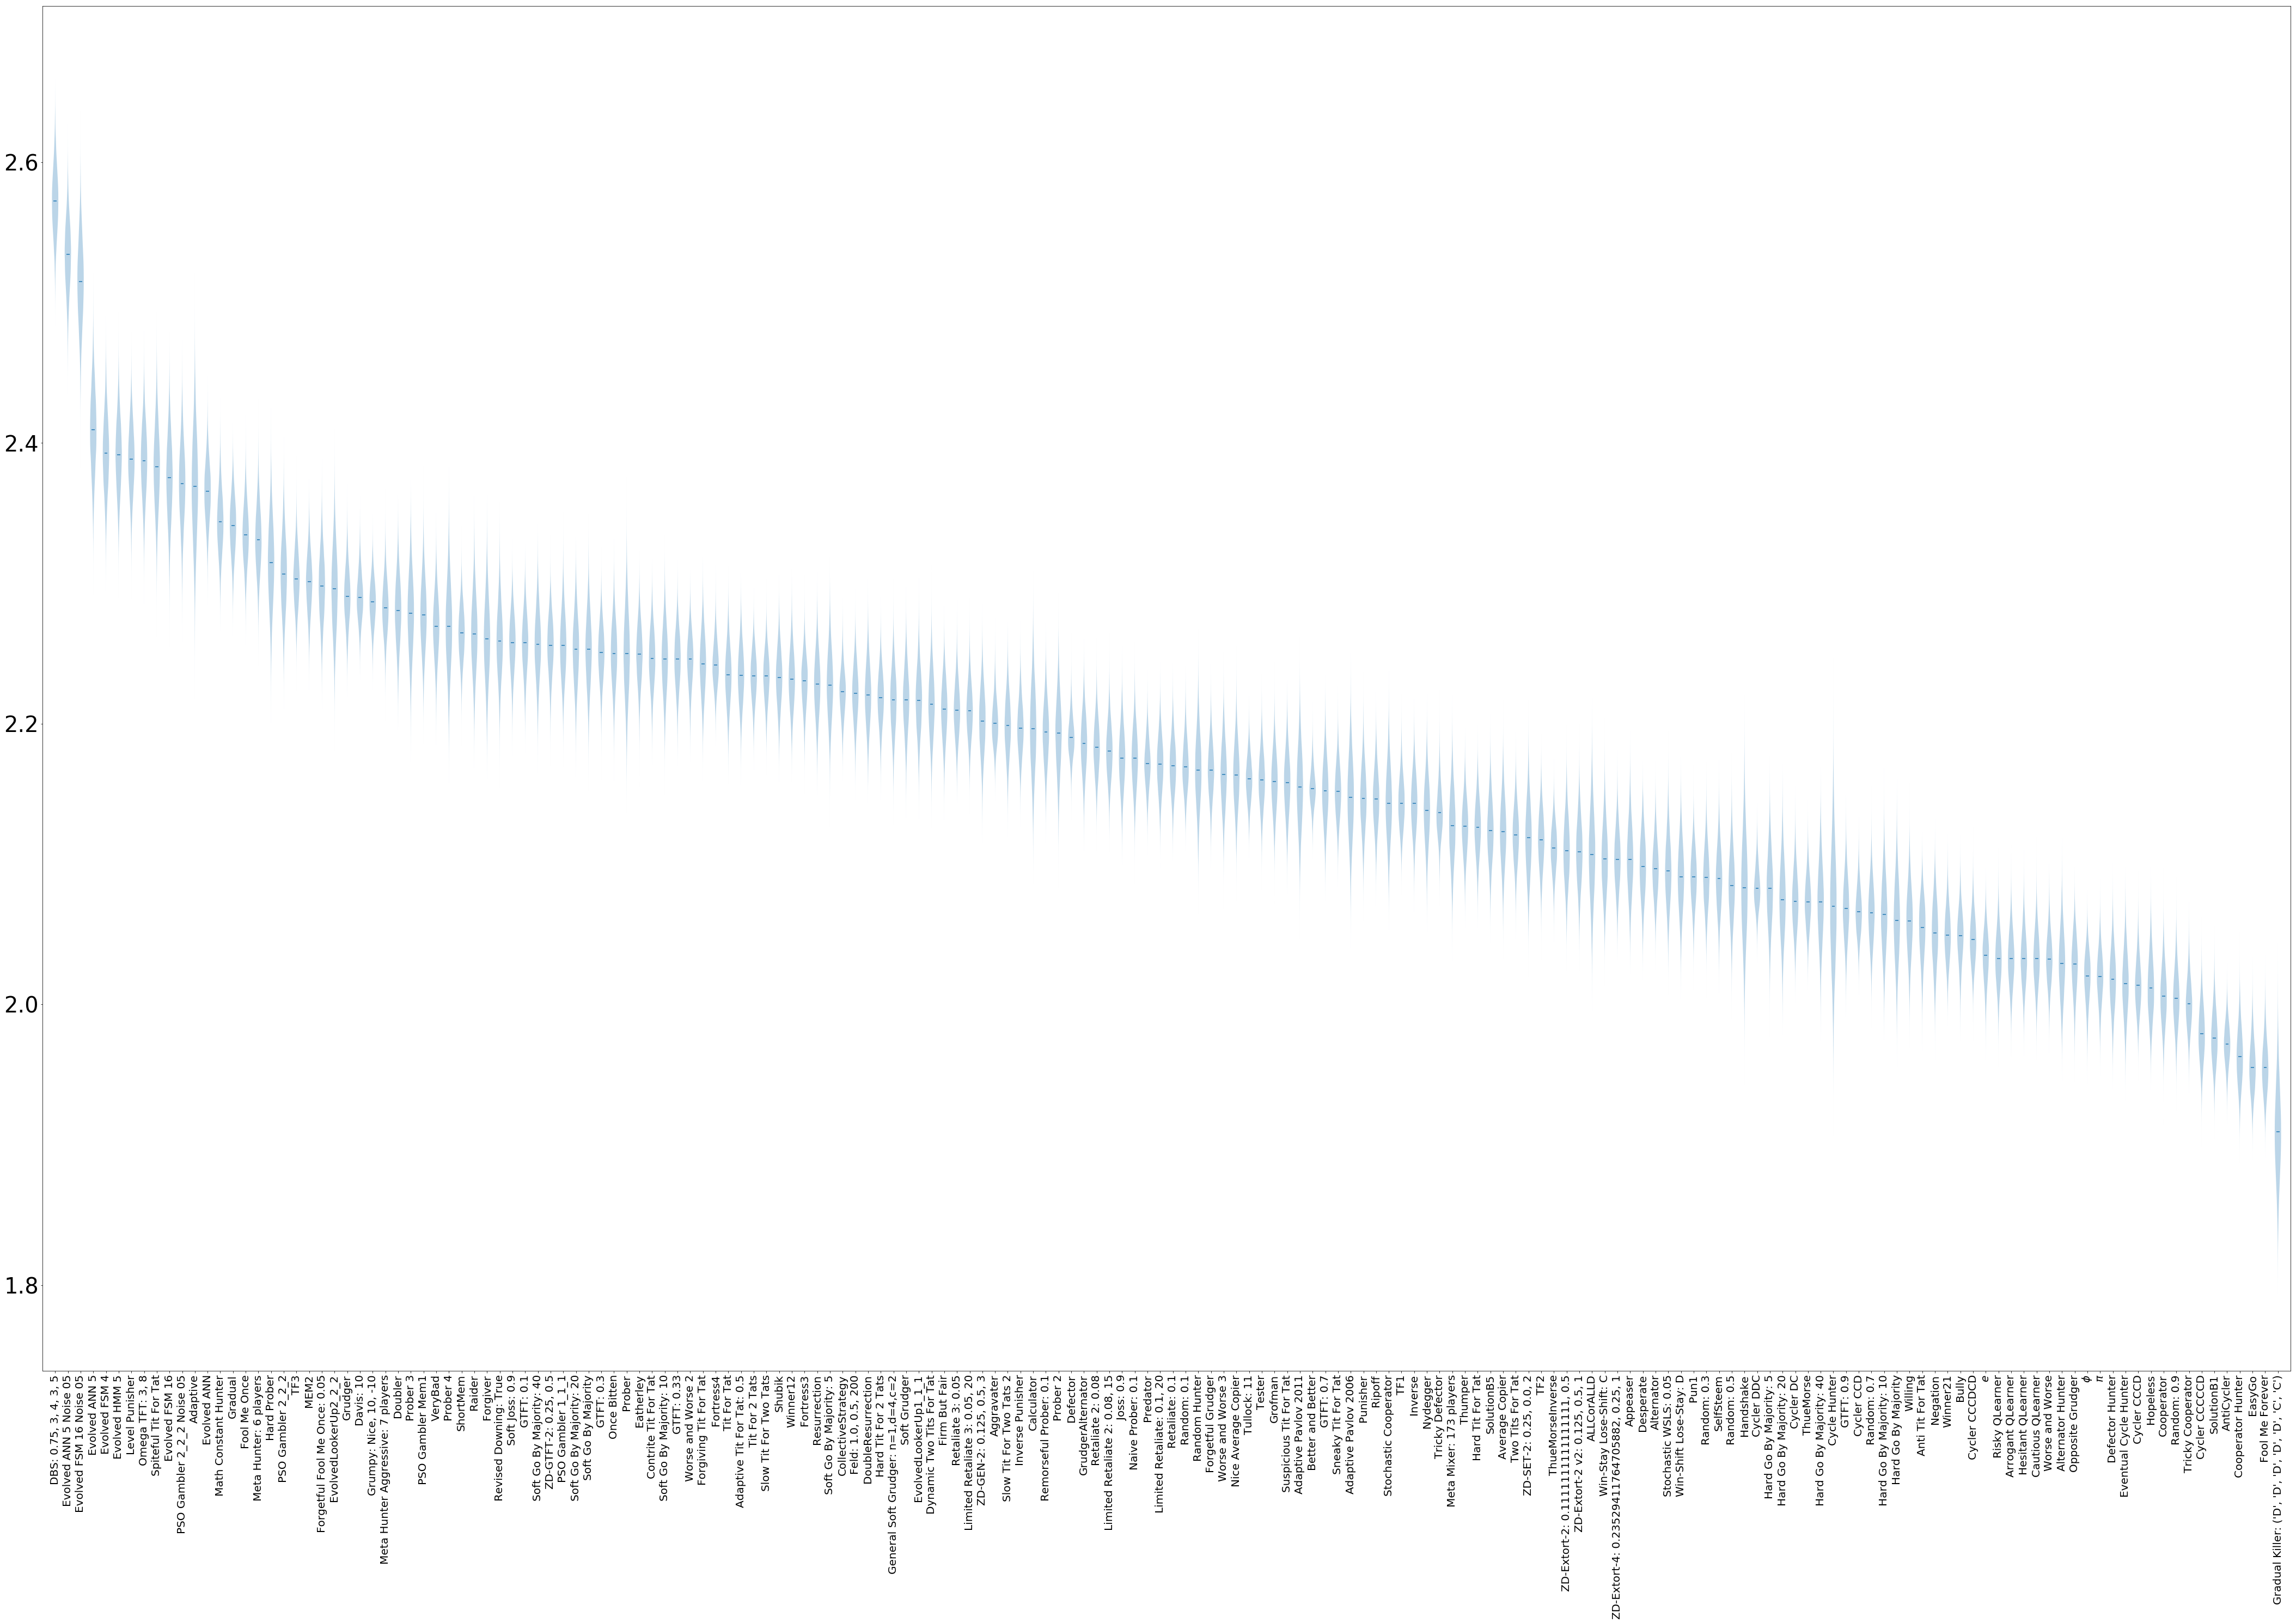

In [23]:
violon_plot(scores, score_summary, "../assets/noisy_scores_boxplots.pdf")

## Ranks

In [24]:
rank_summary = summarise_ranks(scores)
rank_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
DBS: 0.75, 3, 4, 3, 5        1.205500  0.468957    1   1.0   1.0   1.0   1.0   
Evolved ANN 5 Noise 05       2.184939  0.627989    1   1.0   2.0   2.0   3.0   
Evolved FSM 16 Noise 05      2.624939  0.621003    1   1.0   2.0   3.0   3.0   
Evolved ANN 5                6.370485  2.782239    2   4.0   4.0   5.0   8.0   
Evolved FSM 4                7.924833  3.186004    3   4.0   5.0   7.0  10.0   
Evolved HMM 5                8.016379  3.120466    3   4.0   6.0   7.0  10.0   
Level Punisher               8.337530  3.090044    3   4.0   6.0   8.0  10.0   
Omega TFT: 3, 8              8.517894  3.263055    3   4.0   6.0   8.0  11.0   
Spiteful Tit For Tat         9.165515  3.773007    3   4.0   6.0   9.0  12.0   
Evolved FSM 16              10.198773  4.093008    3   4.0   7.0  10.0  13.0   
PSO Gambler 2_2_2 Noise 05  10.761818  4.099080    3   5.0   8.0  10.0  13.0   
Evolved ANN                 11.342939  3.239739    3   6.0   9.0  11.0  13.0   
Adaptive                    11.402015  5.743308    3   4.0   7.0  11.0  14.0   
Math Constant Hunter        14.667455  3.801593    3   9.0  12.0  15.0  17.0   
Gradual                     15.166758  3.677610    4  10.0  13.0  15.0  17.0   

                             95%  max  
DBS: 0.75, 3, 4, 3, 5        2.0    3  
Evolved ANN 5 Noise 05       3.0    5  
Evolved FSM 16 Noise 05      3.0    9  
Evolved ANN 5               12.0   24  
Evolved FSM 4               14.0   33  
Evolved HMM 5               14.0   26  
Level Punisher              14.0   26  
Omega TFT: 3, 8             14.0   32  
Spiteful Tit For Tat        16.0   40  
Evolved FSM 16              17.0   51  
PSO Gambler 2_2_2 Noise 05  18.0   47  
Evolved ANN                 17.0   32  
Adaptive                    21.0   63  
Math Constant Hunter        21.0   43  
Gradual                     21.0   49

In [25]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(rank_summary.head(15).round(number_of_digits).to_latex()))

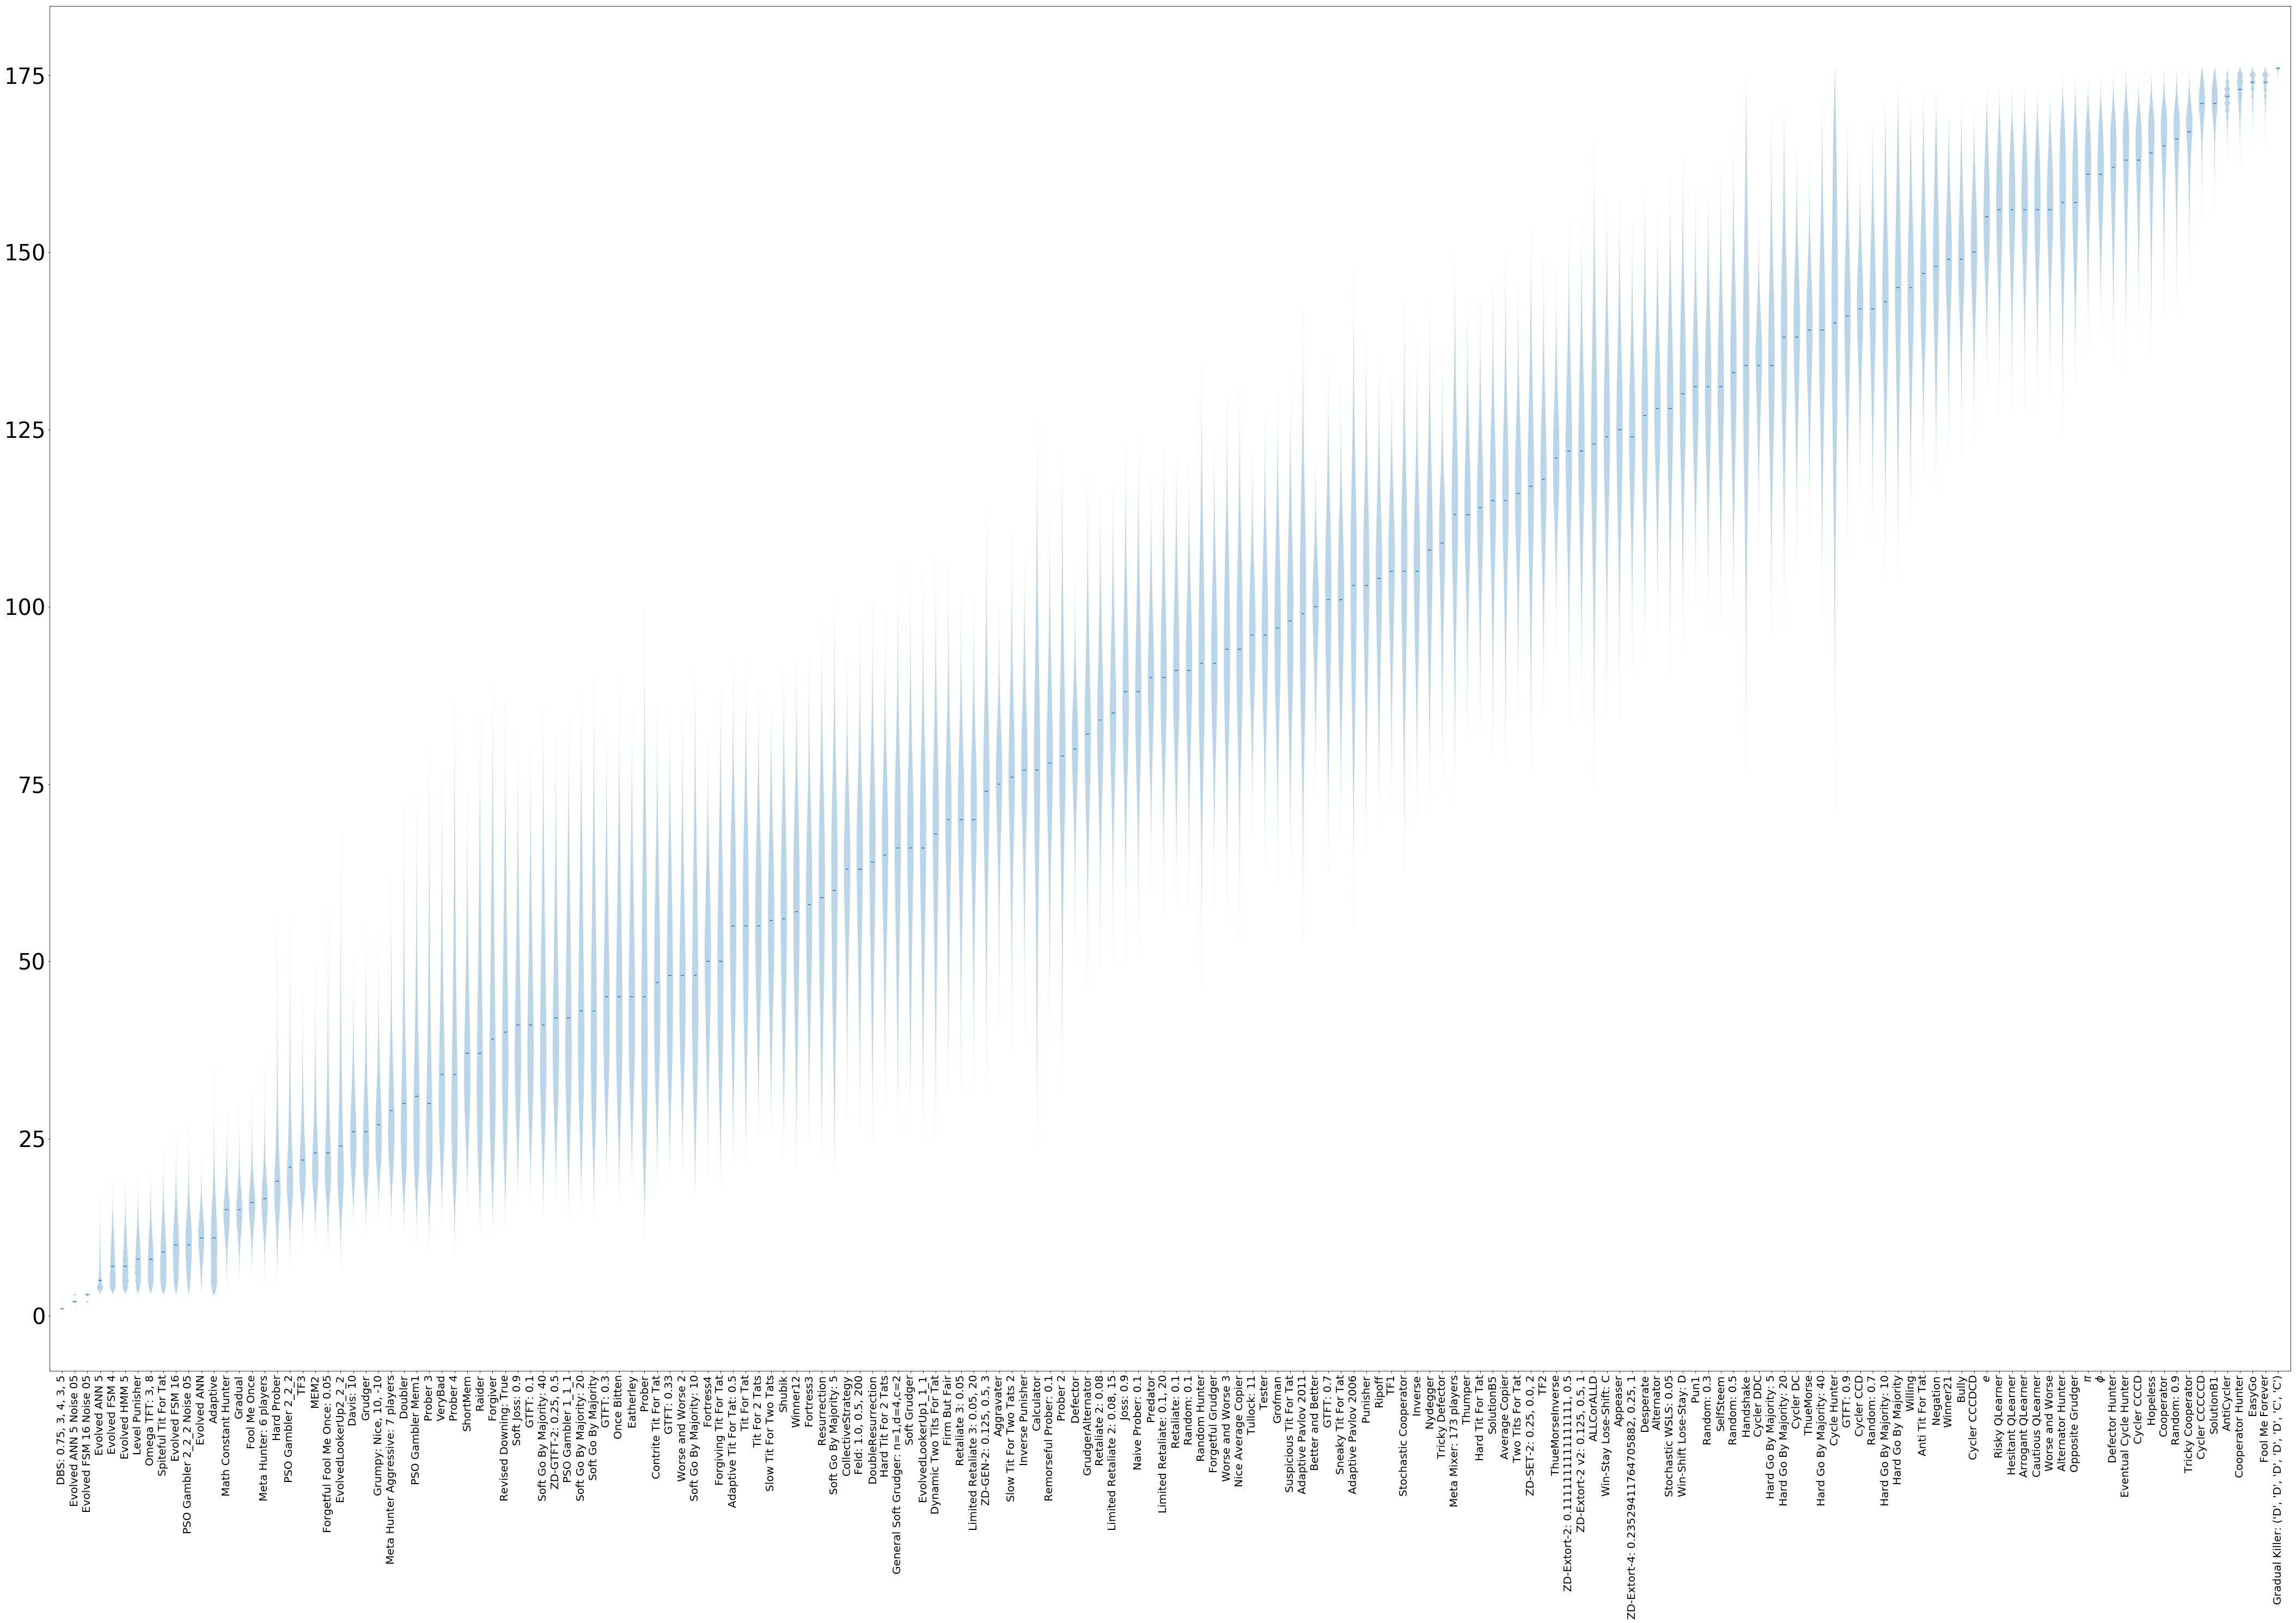

In [26]:
violon_plot(scores.rank(axis=1, ascending=False), rank_summary, "../assets/noisy_ranks_boxplots.pdf")

## Payoff matrix

In [27]:
payoff_matrix = read_payoff_matrix(files=noisy_files)
assert payoff_matrix.shape == (176, 176)

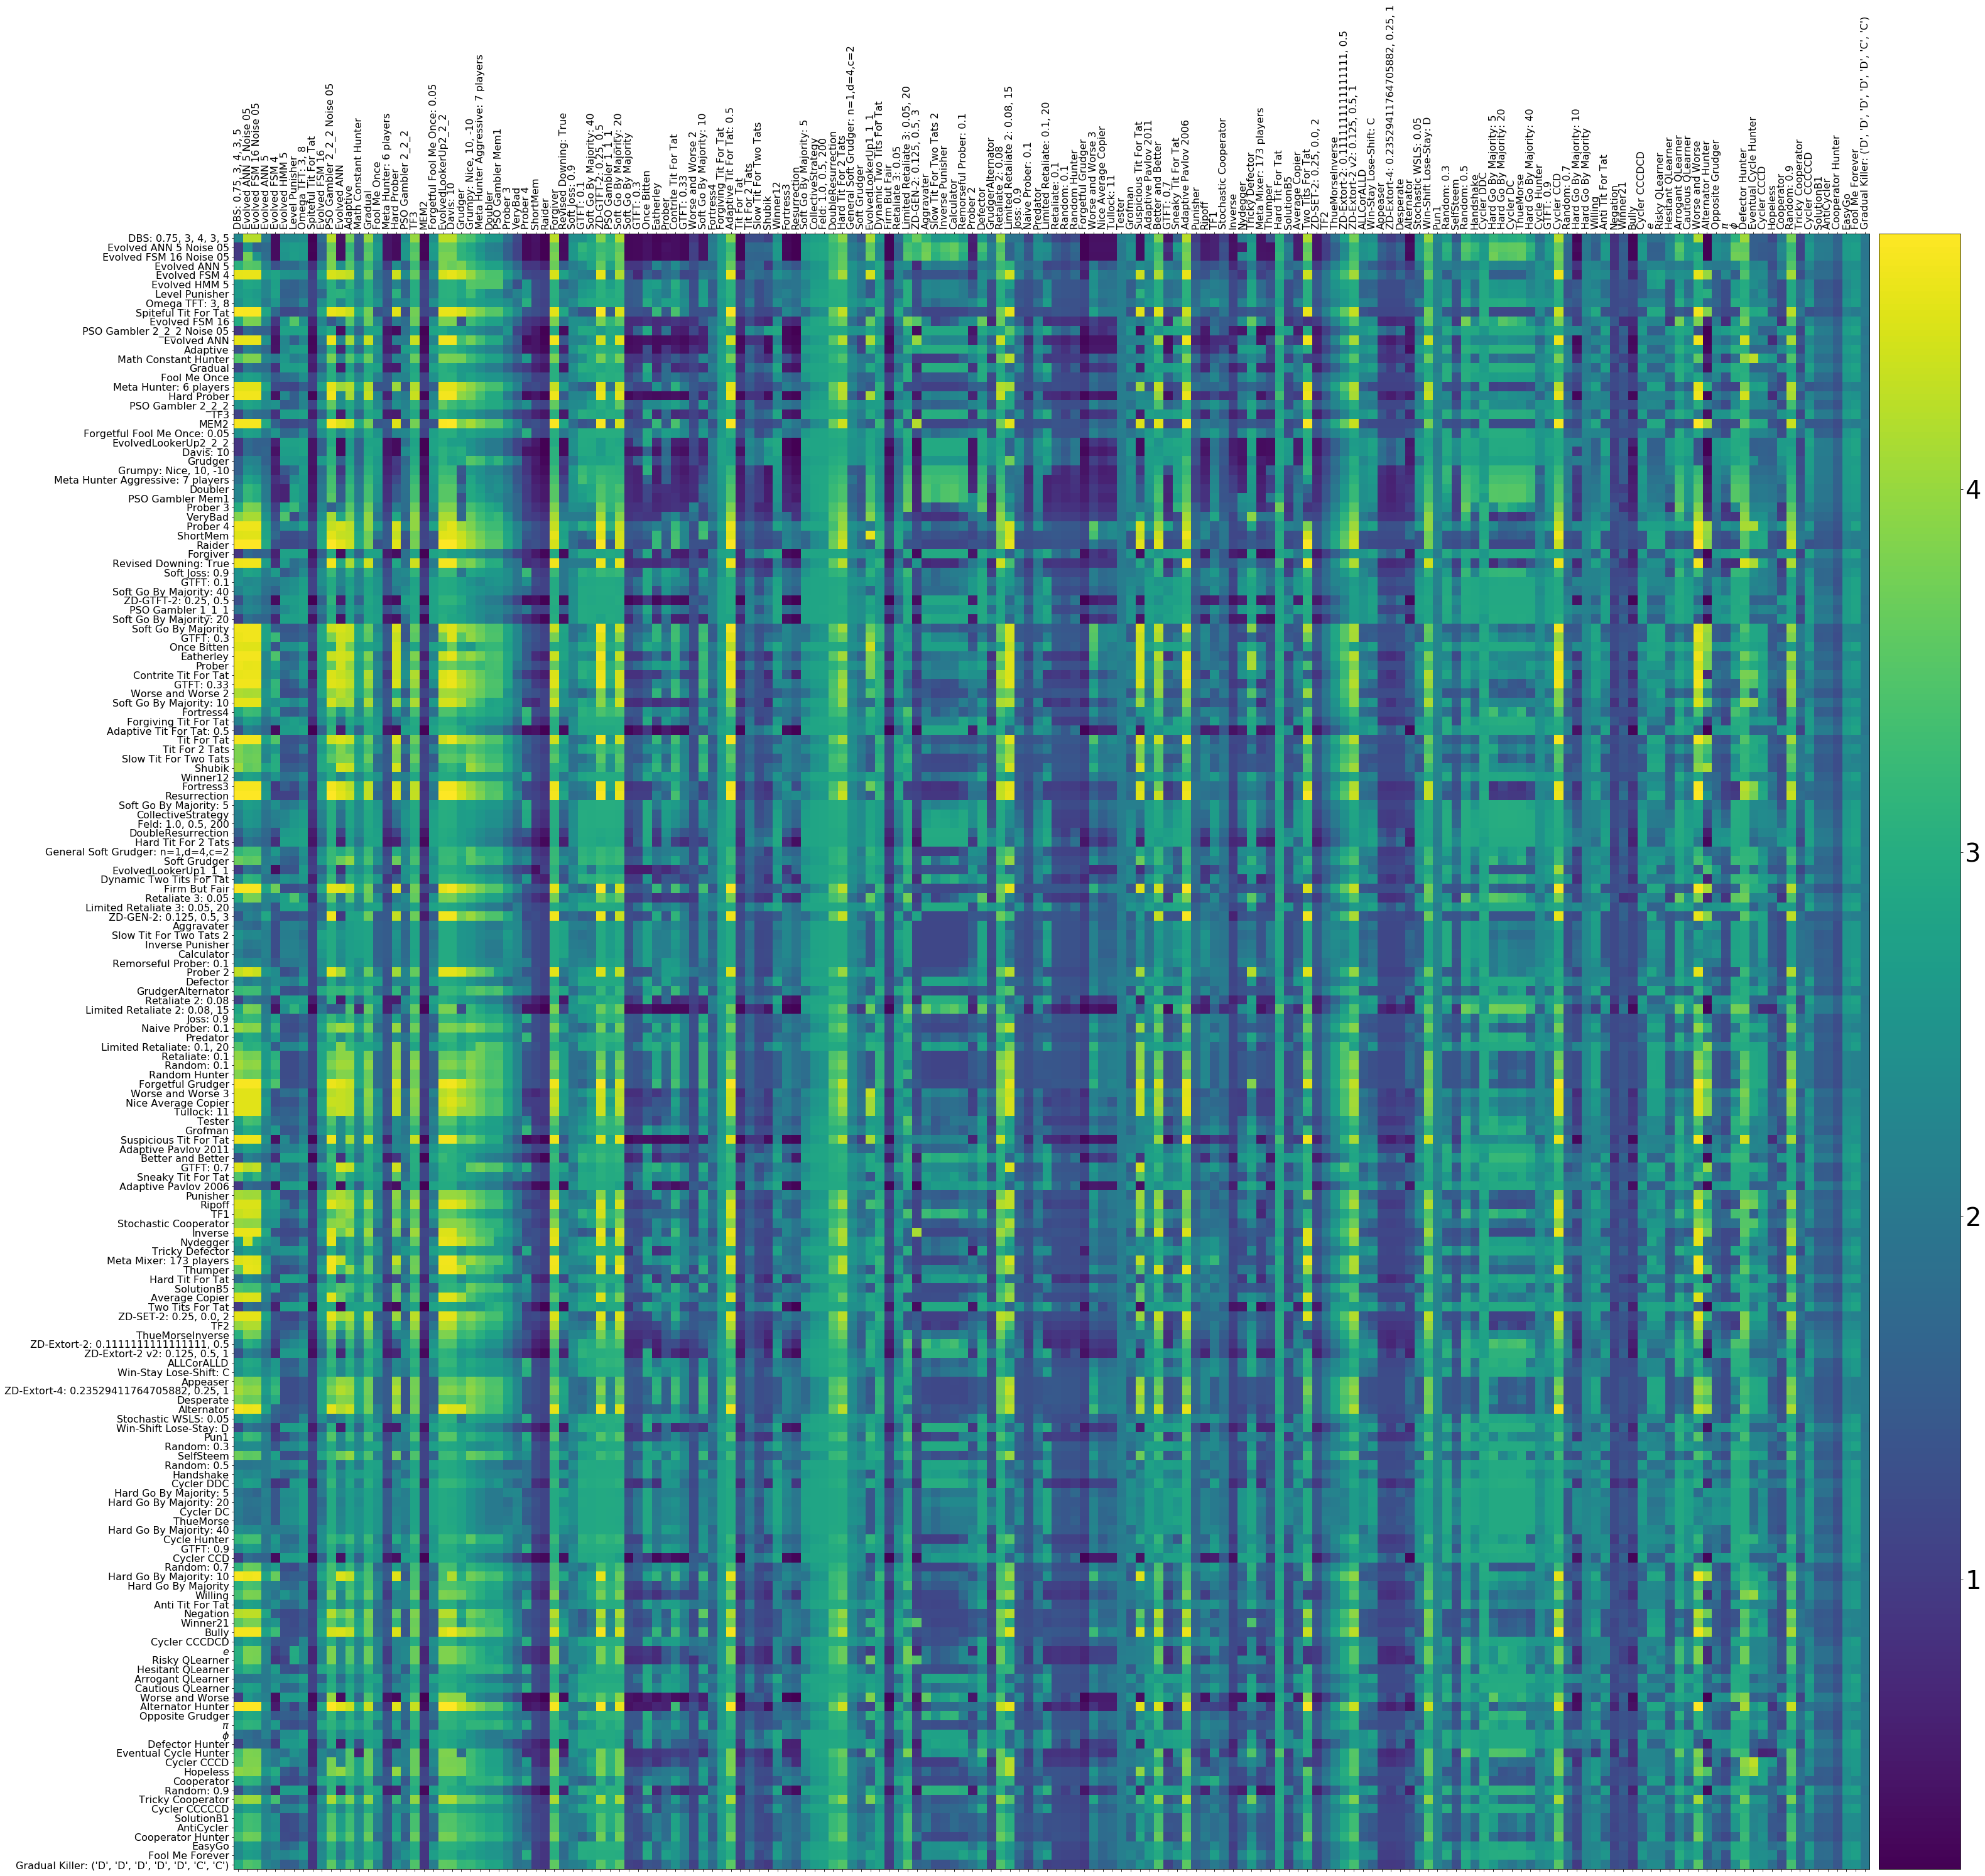

In [28]:
ranked_player_names = list(rank_summary.index)
ranked_indices = [player_names.index(name) for name in ranked_player_names]
ranked_payoff_matrix = payoff_matrix[ranked_indices][:, ranked_indices]
payoff_heatmap(payoff_matrix, ranked_player_names, "../assets/noisy_scores_heatmap.pdf")

## Wins

In [29]:
wins = read_wins(files=noisy_files)

In [30]:
win_summary = summarise_wins(wins, score_summary)
win_summary.head(15)

mean       std  min     5%    25%    50%  \
DBS: 0.75, 3, 4, 3, 5       102.572939  3.678059   87   97.0  100.0  103.0   
Evolved ANN 5 Noise 05       75.030788  4.227710   59   68.0   72.0   75.0   
Evolved FSM 16 Noise 05      88.732333  3.872669   74   82.0   86.0   89.0   
Evolved ANN 5               137.863667  4.358748  118  131.0  135.0  138.0   
Evolved FSM 4                74.245848  2.681201   64   70.0   72.0   74.0   
Evolved HMM 5                88.190000  2.776615   77   84.0   86.0   88.0   
Level Punisher               94.278152  4.771178   77   86.0   91.0   94.0   
Omega TFT: 3, 8             131.677364  4.301389  112  125.0  129.0  132.0   
Spiteful Tit For Tat        155.034515  3.328931  133  150.0  153.0  155.0   
Evolved FSM 16              103.292727  3.641218   89   97.0  101.0  103.0   
PSO Gambler 2_2_2 Noise 05   90.515758  4.013220   75   84.0   88.0   90.0   
Adaptive                    101.873848  4.902182   84   94.0   99.0  102.0   
Evolved ANN                 138.510788  3.389581  125  133.0  136.0  139.0   
Math Constant Hunter         93.006667  3.272888   79   88.0   91.0   93.0   
Gradual                     101.888152  2.856764   91   97.0  100.0  102.0   

                              75%    95%  max  
DBS: 0.75, 3, 4, 3, 5       105.0  109.0  118  
Evolved ANN 5 Noise 05       78.0   82.0   93  
Evolved FSM 16 Noise 05      91.0   95.0  104  
Evolved ANN 5               141.0  145.0  156  
Evolved FSM 4                76.0   79.0   85  
Evolved HMM 5                90.0   93.0   99  
Level Punisher               97.0  102.0  116  
Omega TFT: 3, 8             135.0  139.0  150  
Spiteful Tit For Tat        157.0  160.0  167  
Evolved FSM 16              106.0  109.0  118  
PSO Gambler 2_2_2 Noise 05   93.0   97.0  107  
Adaptive                    105.0  110.0  122  
Evolved ANN                 141.0  144.0  152  
Math Constant Hunter         95.0   98.0  107  
Gradual                     104.0  107.0  114

In [31]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.head(15).round(number_of_digits).to_latex()))

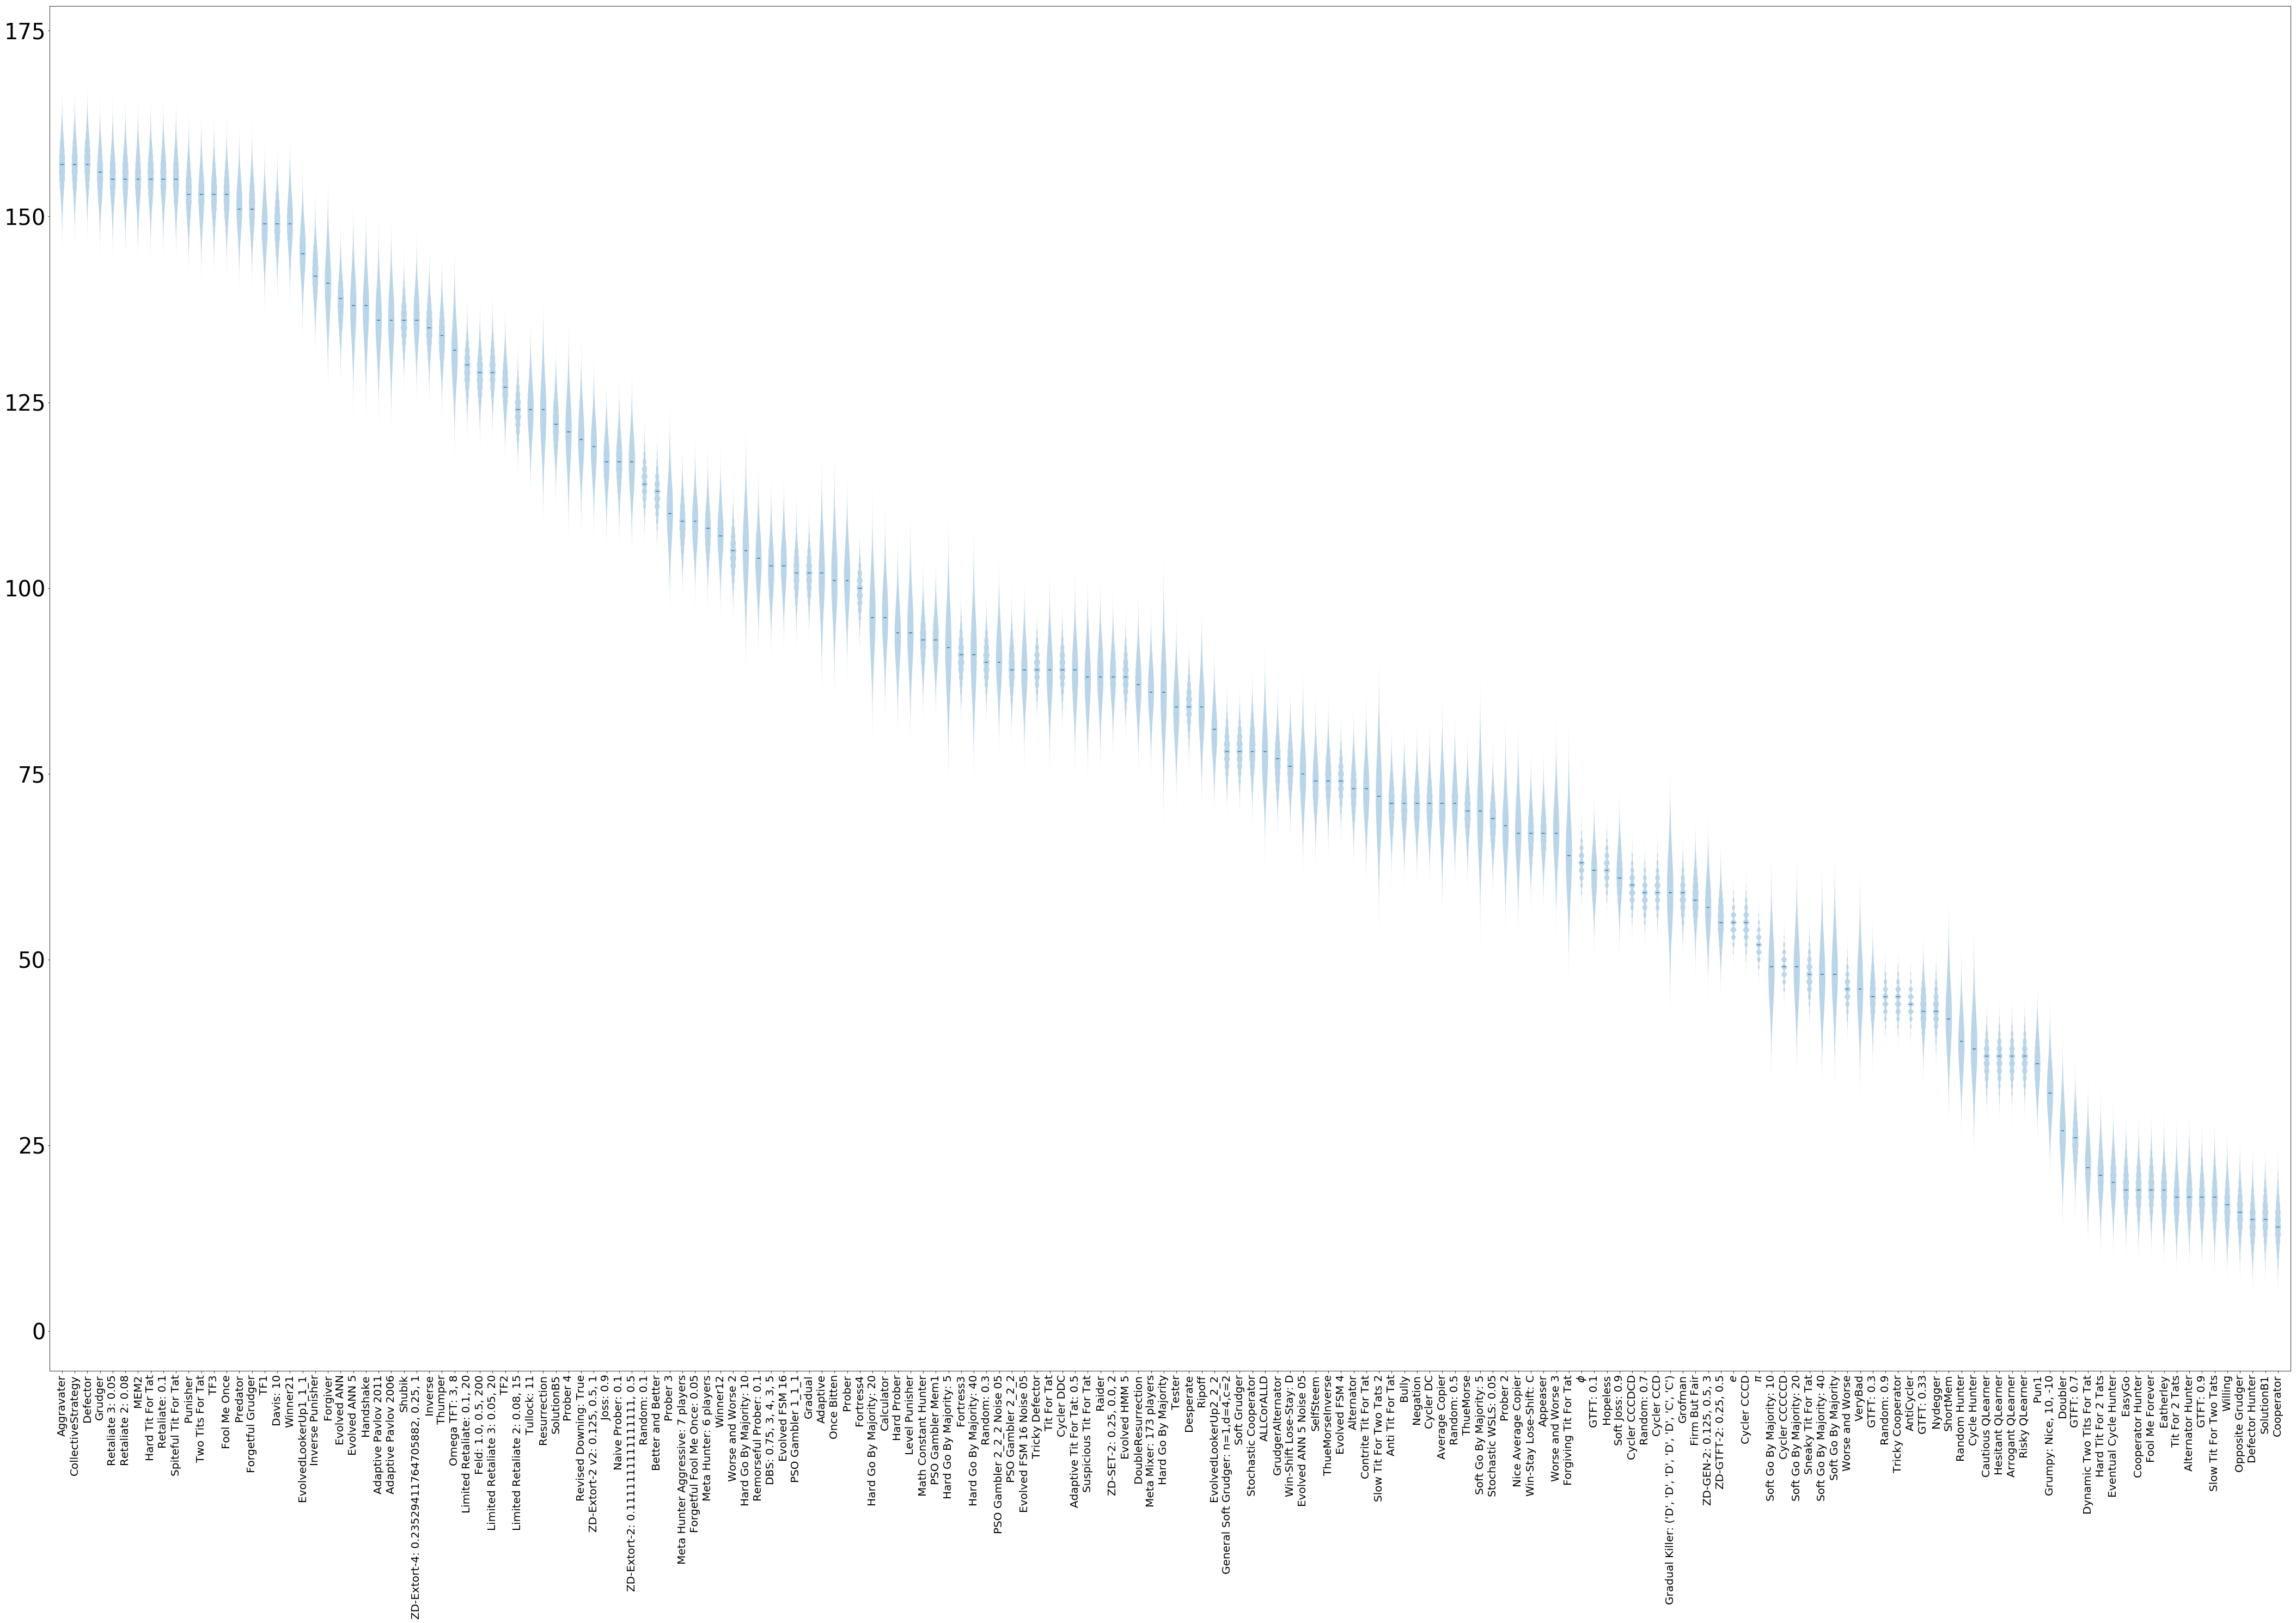

In [32]:
win_summary = win_summary.sort_values("50%", ascending=False)
violon_plot(wins, win_summary, "../assets/noisy_wins_boxplots.pdf")